# **Skin Cancer Detection from Dermoscopic Images Using Deep Convolutional Neural Networks (CNN)**

##**Project Objective**

The goal of this capstone is to predict whether a dermoscopic image (skin image) is malignant (skin cancer) using low-resolution images combined with a small set of patient metadata. The emphasis is on building a realistic, reproducible pipeline under practical constraints rather than maximizing benchmark performance.

##**Dataset and Practical Constraints**

This project is based on The International Skin Imaging Collaboration (ISIC) 2020 'Skin Lesion Analysis: Towards Melanoma Detection' dataset (≈33,000 images, ~50GB in full resolution). https://challenge2020.isic-archive.com/

Working with the original high-resolution dermoscopic images was not feasible for this capstone due to storage limits and compute constraints. To address this, I used a pre-resized 224×224 JPG version of the ISIC 2020 dataset available on Kaggle:

https://www.kaggle.com/datasets/nischaydnk/isic-2020-jpg-224x224-resized

**This decision introduced an important trade-off**: This is an extemely difficult dataset as it has extreme imbalance. The model performance is expected to be lower than approaches trained on full-resolution dermoscopy images. This trade-off is intentional due to storage and compute limits as mentioned before.

##**Key Challenges and Design Decisions**

*   **Google Colab instability resolution** Training directly from Google Drive createed a performance and reliability problem because reading thousands of small image files incured high I/O latency and intermittently stalled and disconnected during long runs.  The solution was to copy and unzip the image dataset into the local runtime once, then load metadata, construct file paths, and verify image integrity so training used fast, stable local disk access.

*   **Severe Class Imbalance:** Malignant cases are rare relative to benign lesions. Accuracy calculation is therefore misleading. The model can achieve high accuracy by simply predicting the majority class (Benign or not cancer) most of the time, while completely failing to identify the minority class (malignant or cancer). To properly evaluate performance under imbalance, **PR-AUC (Precision-Recall Area Under Curve)** was used as the primary evaluation metric, with **ROC-AUC (Receiver Operating Characteristic Area Under Curve)** reported as a secondary reference

*   **Leakage Prevention:** There are multiple images per patient in the dataset and the images are highly correlated. To avoid leakage, I have split the dataset strictly at the **patient level** using patient_id, to ensure that no patient appears in more than one of train, validation, or test sets.

*  **Image level prevalance** Malignant images are rare in the dataset, so care had to be taken to ensure that the right proportion of maligant images were in train, val and test datasets.

##**Exploratory Data Analysis (EDA)**

A very limited set of metadata were provided with the images. The following was done:

*   Missing-value and metadata sanity checks
*   **Class imbalance analysis:** The splits had to be carefully done to ensure both benign and malignant images were present in the train, val and test dataset in similar proportions.
*   **Patient-level distribution checks:** Ensured that the train, val , test splits did not contain the same patient's dermascoping images.

##**Feature Engineeering**

*  **Age normalization and binning**
Age was converted to a numeric value, bucketed into ordered ranges, and augmented with an explicit missing flag.

*  **Sex and site missingness handling**
Missing sex and anatomical site values were encoded using binary indicators and  "Unknown" category.

*  **Anatomical site consolidation**
Rare anatomical sites were grouped into an "Other" category using training-only split to reduce sparsity and overfitting.

*  **Categorical interaction features**
Sex–site and age–site interaction features were created to capture conditional risk patterns beyond marginal effects.

*  **Leakage-safe default handling**
Unseen patients were assigned neutral defaults, with positive-rate imputation based on the training-set mean only.

*  **Split-safe application**
All feature statistics were learned on the training set and applied identically to train, validation, and test splits.

##**Models Implemented**

###**1. Baseline Model with metadata: LogisticRegression**

Used patient-level metadata with guaranteed malignant/ benign data within train, val test, data to establish a baseline. this also demonstrates the predictive value of metadata alone.

###**2.LogisticRegression with Hyperparameter tuning - Cross Validation and GridSearch**
Class-weighted Logistic Regression (which up-weights the rare positive class to counter the 1–2% prevalence) is fitted and tuned with **5-fold GroupKFold** by patient_id to avoid same-patient leakage across folds. Then **GridSearch** explores **L1 vs L2 regularization** (sparsity/selective feature use vs smooth shrinkage) and **different regularization strengths** (C) to select the best setting by **cross-validated** PR-AUC.

###**3. Baseline Model with metadata: Gradient Boosted Decision Trees (GBDT) - HistGradientBoostingClassifier**

Trained a metadata-only **HistGradientBoostingClassifier** with one-hot encoded categorical features and median-imputed numeric features. I used HistGradientBoostingClassifier because **Gradient Boosted Decision Trees** can capture non linear relationships and feature interactions that logistic regression often misses.

###**4. Image-Only Convolutional Neural Network (CNN) Model EfficientNet-B0**

*(EfficientNet-b0 is a convolutional neural network that is trained on more than a million images from the ImageNet database.)*
I used reduced size 224×224 pixel dermoscopic images in all CNN models.

I chose it because it is widely used for image classification, often outperforming much larger models like ResNet with significantly fewer parameters. Pretrained on ImageNet dataset images features that transfer well, so head-only training is a reliable.

Training strategy: Freeze backbone and train only classifier head.

Used (torchvision) for light augmentation (flip and small rotation).

Imbalance handling: Used pos_weight = neg/pos inside **BCEWithLogitsLoss** to upweight positives (malignant).

Used **AdamW** optimizer during training to update the model’s trainable weights and to reduce the **loss**.


###**5. Convolutional Neural Network (CNN) Model - EfficientNet-B0 with image aumentaion using Albumentations**

The training pipeline uses **Albumentations** to apply a richer and more diverse set of image augmentations. Each training image is first **resized** to a fixed input size. It is then **randomly flipped horizontally and vertically** to improve invariance to orientation. Next, an affine transformation is applied, which includes **small random translations, scaling, and rotations** of up to ±20 degrees to **increase geometric robustness**.

After the geometric transformations, **color and illumination variations** are introduced through random **brightness and contrast adjustments, hue and saturation shifts, and gamma corrections**. To further improve robustness to image quality variations common in real-world data, the pipeline occasionally applies **mild blurring or Gaussian noise**. Finally, the image is normalized using ImageNet mean and standard deviation and converted into a PyTorch tensor using ToTensorV2

Training strategy is the same as before, freeze backbone and train only classifier head.


###**6. Convolutional Neural Network (CNN) Model - EfficientNet-B0 classifier using a two-stage fine-tuning approach with Albumentations-based image augmentation**

* Images are resized, augmented, normalized with ImageNet statistics, and converted to tensors, while class imbalance is handled using a weighted binary cross-entropy loss.
* **In Stage 1**, the pretrained backbone is frozen and only the classifier head is trained, with validation PR-AUC used for early stopping and checkpoint selection.
* **In Stage 2**, the best Stage 1 model is reloaded and only the final EfficientNet block plus the classifier head are fine-tuned using a lower learning rate for the backbone.
* The final model is evaluated on the test set using PR-AUC and ROC-AUC.

###**7. STACKING - Convolutional Neural Network (CNN) Model - EfficientNet-B0 with Metadata Probability**

* Here CNN image-based probabilities and metadata-based probabilities are combined by training a logistic regression model on the validation set.
* The stacked model is then evaluated on the test set and compared against the standalone CNN and metadata models to measure performance gains.

###**8. Convolutional Neural Network (CNN) Model - EfficientNet-B0 classifier using a two-stage fine-tuning approach with Albumentations-based image augmentation and imbalance handling with WeightedRandomSampler**

Two-stage fine-tune: (S1) head-only, (S2) last block + head (lower LR)
Imbalance handling : WeightedRandomSampler
Loss : BCEWithLogitsLoss
Stronger Albumentations aug: Affine and color and blur/noise and coarse dropout

Best reseults.

##**Going above and Beyond**

I have used the Model weights and Gradio 6.3.0 to create an UI based application in HuggingFace Spaces
**Skin Lesion Risk Demo**
This App

* accepts a skin lesion photo upload
* runs EfficientNet-B0 inference from a saved .pt checkpoint
* shows probability + decision at a chosen threshold
* shows Grad-CAM overlay and heatmap
* provides Q&A using RAG + OpenAI API


In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Standard package imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os, gc, logging, random, shutil, zipfile
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple, Set, Mapping, Sequence, Callable, Optional
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, confusion_matrix, precision_recall_curve, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import GroupKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
import torch
from PIL import Image
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import models, transforms
from torch.amp import autocast, GradScaler
import albumentations as A
from albumentations.pytorch import ToTensorV2




## Activate logging

In [3]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s", force=True)
logger = logging.getLogger("capstone")

## Path definitions

In [4]:
project_drive_path_str = "/content/drive/MyDrive/final_capstone_project"
project_drive_root = Path(project_drive_path_str)

raw_data_directory = project_drive_root / "raw"
artifact_output_directory = project_drive_root / "artifacts"
metadata_directory = project_drive_root / "meta"

local_dataset_root = Path("/content/datasets/isic2020_256")
local_data_directory = Path("/content/datasets/isic2020_256/data")

# Ensure directories exist
raw_data_directory.mkdir(parents=True, exist_ok=True)
artifact_output_directory.mkdir(parents=True, exist_ok=True)
metadata_directory.mkdir(parents=True, exist_ok=True)
local_dataset_root.mkdir(parents=True, exist_ok=True)

logger.info(
    "raw_dir: %s\n artifacts_dir: %s\n meta_dir: %s\n data_dir: %s ",
    raw_data_directory, artifact_output_directory, metadata_directory, local_data_directory
)



INFO: raw_dir: /content/drive/MyDrive/final_capstone_project/raw
 artifacts_dir: /content/drive/MyDrive/final_capstone_project/artifacts
 meta_dir: /content/drive/MyDrive/final_capstone_project/meta
 data_dir: /content/datasets/isic2020_256/data 


## Utility functions

In [5]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)


# Check if a given pandas DataFrame contains all the specified columns.
def require_columns(df: pd.DataFrame, required: Sequence[str]) -> None:
    missing_cols = [c for c in required if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")


#  outputs example "loss=0.21 | epoch=3 | split=val"
def info_dict(fields: Mapping[str, object]) -> str:
    parts = (f"{key}={value}" for key, value in fields.items())
    return " | ".join(parts)

#plots
def plot_model_diagnostics(y_true,y_prob,*,name="TEST",color=None,bins=50,threshold=0.5):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    prevalence = y_true.mean()
    fig, axes = plt.subplots(1, 5, figsize=(28, 4))

    #Precision–Recall
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)

    axes[0].plot(recall, precision, color=color)
    axes[0].axhline(prevalence, linestyle="--", alpha=0.6)
    axes[0].set_title(f"{name} Precision–Recall\nPR-AUC={pr_auc:.4f} | baseline={prevalence:.4f}")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")

    #Cumulative recall
    sorted_idx = np.argsort(-y_prob)
    y_sorted = y_true[sorted_idx]

    cumulative_tp = np.cumsum(y_sorted)
    total_tp = y_true.sum()
    frac_reviewed = np.arange(1, len(y_true) + 1) / len(y_true)

    cumulative_recall = (cumulative_tp / total_tp if total_tp > 0 else np.zeros_like(cumulative_tp))

    axes[1].plot(frac_reviewed * 100, cumulative_recall * 100, color=color)
    axes[1].plot([0, 100], [0, 100], linestyle="--", alpha=0.6)
    axes[1].set_title(f"{name} Cumulative Recall")
    axes[1].set_xlabel("% of images reviewed")
    axes[1].set_ylabel("% of positives found")

    #Score distributions
    axes[2].hist(y_prob[y_true == 0], bins=bins, alpha=0.6, label="Negative")
    axes[2].hist(y_prob[y_true == 1], bins=bins, alpha=0.6, label="Positive")
    axes[2].set_title(f"{name} Score Distribution")
    axes[2].set_xlabel("Predicted probability")
    axes[2].set_ylabel("Count")
    axes[2].legend()

    #ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    axes[3].plot(fpr, tpr, color=color)
    axes[3].plot([0, 1], [0, 1], linestyle="--", alpha=0.6)
    axes[3].set_title(f"{name} ROC\nAUC={roc_auc:.4f}")
    axes[3].set_xlabel("False Positive Rate")
    axes[3].set_ylabel("True Positive Rate")

    # Confusion matrix
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    norm = LogNorm(vmin=1, vmax=cm.max())

    im = axes[4].imshow(cm, cmap="Blues", norm=norm)
    axes[4].set_title(f"{name} Confusion Matrix\n(threshold={threshold:.2f})")

    axes[4].set_xticks([0, 1])
    axes[4].set_yticks([0, 1])
    axes[4].set_xticklabels(["Pred 0", "Pred 1"])
    axes[4].set_yticklabels(["True 0", "True 1"])

    for i in range(2):
        for j in range(2):
            axes[4].text(j,i,cm[i, j],ha="center",va="center",fontsize=12,fontweight="bold",color="black")

    plt.tight_layout()
    plt.show()


## Instability issue resolution

Processing image files from 'My Drive' of google was creating instability and not completing. So I updated the code to move the image files to local google runtime disk that is allocated per session. I ofcourse keep the image zip file in 'My Drive' directory but for every run unzip it to local sessions disk and  process it. this makes the execution smoother and faster.




In [6]:
#Locate the zip file
zip_files = sorted(raw_data_directory.glob("*.zip"))
if not zip_files:
    raise FileNotFoundError(f"No .zip found in {raw_data_directory}")

dataset_zip = zip_files[0]
if len(zip_files) > 1:
    print(f"Multiple zips found; using: {dataset_zip.name}")


#unzip to local runtime
images_dir = local_dataset_root/"train-image"/"image"

if not images_dir.exists():
    runtime_zip = Path("/content/isic2020_256.zip")
    if not runtime_zip.exists():
        print("Copying zip to local runtime...")
        shutil.copyfile(dataset_zip, runtime_zip)

    print(f"Unzipping into: {local_dataset_root}")
    with zipfile.ZipFile(runtime_zip, "r") as zf:
        zf.extractall(local_dataset_root)

    if not images_dir.exists():
        raise RuntimeError(f"Expected image folder missing after unzip: {images_dir}")
else:
    print("Images already present; skipping unzip")


#load the metadata file
meta_csv = metadata_directory / "train-metadata-new.csv"
if not meta_csv.exists():
    raise FileNotFoundError(f"Metadata CSV not found: {meta_csv}")

df = pd.read_csv(meta_csv)


# Verify that image files vexist
df["filepath"] = df["image_name"].astype(str).map(lambda name: str(images_dir / f"{name}.jpg"))

missing_images = (~df["filepath"].map(os.path.exists)).sum()
if missing_images:
    raise FileNotFoundError(f"{missing_images} .jpg files missing under: {images_dir}")

print("Loaded:", df.shape)
print("Images:", images_dir)
display(df.head())


Copying zip to local runtime...
Unzipping into: /content/datasets/isic2020_256
Loaded: (33126, 9)
Images: /content/datasets/isic2020_256/train-image/image


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,filepath
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,/content/datasets/isic2020_256/train-image/ima...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,/content/datasets/isic2020_256/train-image/ima...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,/content/datasets/isic2020_256/train-image/ima...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,/content/datasets/isic2020_256/train-image/ima...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,/content/datasets/isic2020_256/train-image/ima...


##Data quality check

,missing_percent
anatom_site_general_challenge,1.590895
age_approx,0.205277
sex,0.196220
image_name,0.000000
patient_id,0.000000
diagnosis,0.000000
benign_malignant,0.000000
target,0.000000
filepath,0.000000


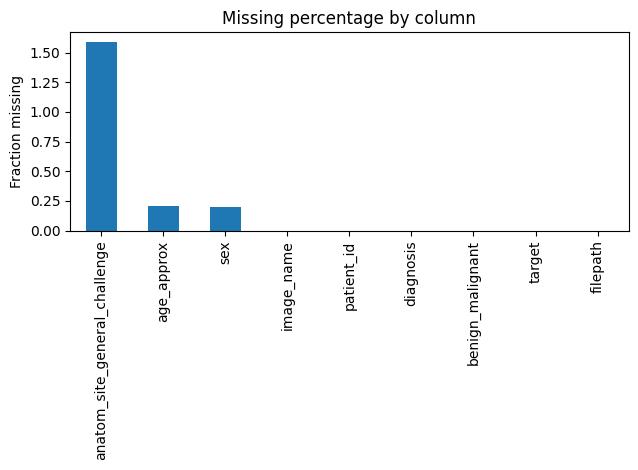

INFO: Duplicates: duplicate_rows=0 | duplicate_image_name=0


In [7]:
# Missing data by column
missing_percentage_by_col = (df.isna().mean() * 100).sort_values(ascending=False)
display(missing_percentage_by_col.to_frame("missing_percent"))

plt.figure()
missing_percentage_by_col.plot(kind="bar")
plt.title("Missing percentage by column")
plt.ylabel("Fraction missing")
plt.tight_layout()
plt.show()

# Duplicates
dup_rows = int(df.duplicated().sum())
dup_image = int(df["image_name"].duplicated().sum())
logger.info("Duplicates: %s", info_dict({"duplicate_rows": dup_rows, "duplicate_image_name": dup_image}))




##Exploratory Data Analysis (EDA)

,count
target,
0,32542
1,584


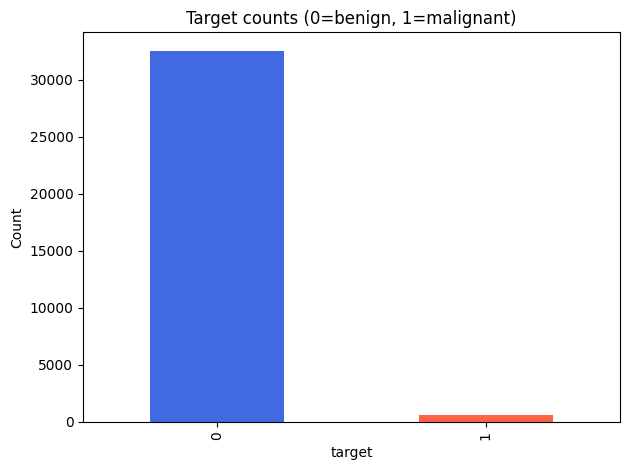

INFO: Dataset summary: target_prevalence=0.01762965646320111 | target_prevalence_percent=1.76 | unique_patients=2056


In [8]:
# Target distribution
target_counts = df["target"].value_counts(dropna=False).sort_index()
display(target_counts.to_frame("count"))

plt.figure()
target_counts.plot(kind="bar", color=["royalblue", "tomato"])
plt.title("Target counts (0=benign, 1=malignant)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Quick dataset summary
logger.info(
    "Dataset summary: %s",
    info_dict(
        {
            "target_prevalence": float(df["target"].mean()),
            "target_prevalence_percent": round(100 * float(df["target"].mean()), 2),
            "unique_patients": int(df["patient_id"].nunique()),
        }
    ),
)


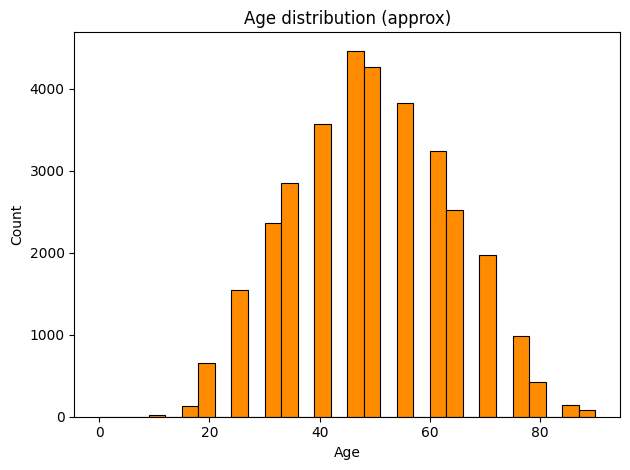

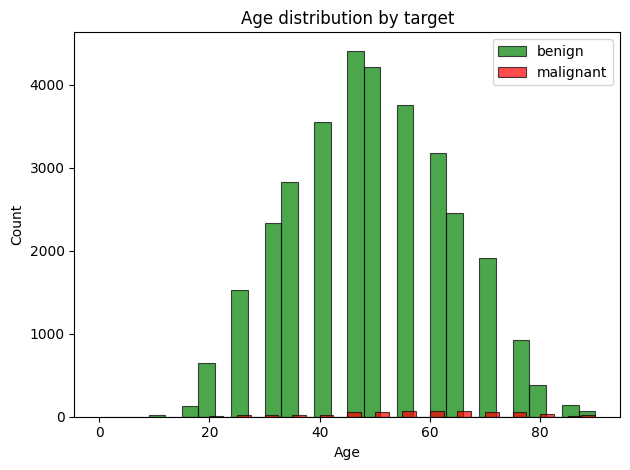

,count
anatom_site_general_challenge,
torso,16845
lower extremity,8417
upper extremity,4983
head/neck,1855
unknown,527
palms/soles,375
oral/genital,124


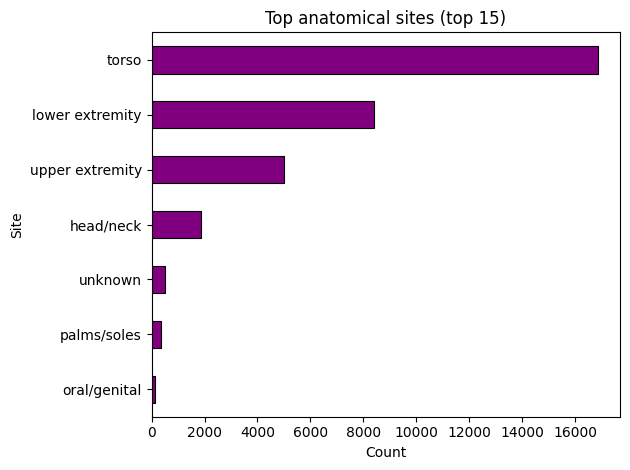

INFO: Patient-level positive rate: 0.2082
INFO: Patient-level positive percentage: 20.82%


In [9]:
# Make age numericand assign NaN to invalid age values
df["age_approx"] = pd.to_numeric(df["age_approx"], errors="coerce")

#plot age distribution in dataset
plt.figure()
df["age_approx"].dropna().plot(kind="hist", bins=30, color="darkorange", edgecolor="black", linewidth=0.8)
plt.title("Age distribution (approx)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# plot Age distribution by target
age_benign = df.loc[df["target"] == 0, "age_approx"].dropna()
age_malignant = df.loc[df["target"] == 1, "age_approx"].dropna()

plt.figure()
age_benign.plot(kind="hist", bins=30, alpha=0.7, label="benign", color="green", edgecolor="black", linewidth=0.8)
age_malignant.plot(kind="hist", bins=30, alpha=0.7, label="malignant", color="red", edgecolor="black", linewidth=0.8)
plt.title("Age distribution by target")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# Top anatomical sites for skin cancer
site_col = df["anatom_site_general_challenge"].fillna("unknown")
site_counts_top15 = site_col.value_counts().head(15)

display(site_counts_top15.to_frame("count"))

plt.figure()
site_counts_top15.sort_values().plot(kind="barh", color="purple", edgecolor="black", linewidth=0.8)
plt.title("Top anatomical sites (top 15)")
plt.xlabel("Count")
plt.ylabel("Site")
plt.tight_layout()
plt.show()

#percentage of patients with cancer in the dataset
patient_has_malignant = df.groupby("patient_id")["target"].max()
logger.info("Patient-level positive rate: %.4f", float(patient_has_malignant.mean()))
logger.info("Patient-level positive percentage: %.2f%%",100 * float(patient_has_malignant.mean()),)









## Train / validation / test split (prevent data leakage by grouping images by patient_id)

A single patient can have multiple images. If the same patient's images appear in Train, Validation or Test dataset, it will be considered data leakage

**How:**  
1) Create a patient-level table with patient level target pt_target = max(target)  Example Patient P1 has 3 dermoscopic images, 2 of them are benign (0) and one is malignant (1). So max(target) will be 1 which will be the patient level target.
2) Split patients into train+val vs test keep the patient patient-level positive rate same for both groups (stratified)    
3) Split train and val patients into train vs val and keep the patient patient-level positive rate same for both groups (stratified)
4) Expand back to image rows and verify zero patient overlap

In [10]:
# Build a patient-level table for stratification (patient is positive if any of their images is malignant)
patient_table = df.groupby("patient_id")["target"].max().reset_index()
patient_table["patient_target"] = patient_table["target"]
patient_table = patient_table.drop(columns=["target"])

#Split into 2 sets, train+val and test and then split train and val keeping positive rate same
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
trainval_idx, test_idx = next(split1.split(patient_table, patient_table["patient_target"]))

trainval_patients = patient_table.iloc[trainval_idx].reset_index(drop=True)
test_patients_tbl = patient_table.iloc[test_idx].reset_index(drop=True)

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
train_idx, val_idx = next(split2.split(trainval_patients, trainval_patients["patient_target"]))

train_patient_ids = set(trainval_patients.iloc[train_idx]["patient_id"])
val_patient_ids   = set(trainval_patients.iloc[val_idx]["patient_id"])
test_patient_ids  = set(test_patients_tbl["patient_id"])

assert train_patient_ids.isdisjoint(val_patient_ids)
assert train_patient_ids.isdisjoint(test_patient_ids)
assert val_patient_ids.isdisjoint(test_patient_ids)


#train_df = all image rows whose patient_id is in train_patient_ids same for val test
train_df = df[df["patient_id"].isin(train_patient_ids)].copy()
val_df   = df[df["patient_id"].isin(val_patient_ids)].copy()
test_df  = df[df["patient_id"].isin(test_patient_ids)].copy()

#sort rows first by patient, then by image id for each patient
train_df = train_df.sort_values(["patient_id", "image_name"]).reset_index(drop=True)
val_df   = val_df.sort_values(["patient_id", "image_name"]).reset_index(drop=True)
test_df  = test_df.sort_values(["patient_id", "image_name"]).reset_index(drop=True)

all_split_patients = train_patient_ids | val_patient_ids | test_patient_ids
assert len(all_split_patients) == patient_table.shape[0], "Some patients were dropped."

def patient_positive_rate_percent(frame: pd.DataFrame) -> float:
    return 100 * float(frame.groupby("patient_id")["target"].max().mean())

logger.info( "Split sizes: %s", info_dict({ "train_rows": len(train_df), "val_rows": len(val_df), "test_rows": len(test_df)}))
logger.info( "Number of patients: %s", info_dict({ "train_patients": len(train_patient_ids),"val_patients": len(val_patient_ids),
             "test_patients": len(test_patient_ids)}))
logger.info( "Patient-level positive rate (%%): %s", info_dict({"train": round(patient_positive_rate_percent(train_df), 2),
             "val": round(patient_positive_rate_percent(val_df), 2),"test": round(patient_positive_rate_percent(test_df), 2)}))

# Save splits
metadata_directory.mkdir(parents=True, exist_ok=True)
train_df.to_csv(metadata_directory / "train_df.csv", index=False)
val_df.to_csv(metadata_directory / "val_df.csv", index=False)
test_df.to_csv(metadata_directory / "test_df.csv", index=False)

train_df_raw = train_df.copy()
val_df_raw   = val_df.copy()
test_df_raw  = test_df.copy()

logger.info("Saved split CSVs to: %s", metadata_directory)

INFO: Split sizes: train_rows=21585 | val_rows=5170 | test_rows=6371
INFO: Number of patients: train_patients=1315 | val_patients=329 | test_patients=412
INFO: Patient-level positive rate (%): train=20.84 | val=20.67 | test=20.87
INFO: Saved split CSVs to: /content/drive/MyDrive/final_capstone_project/meta


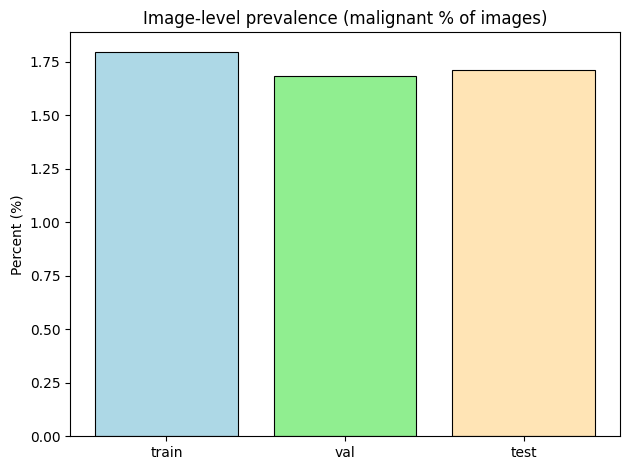

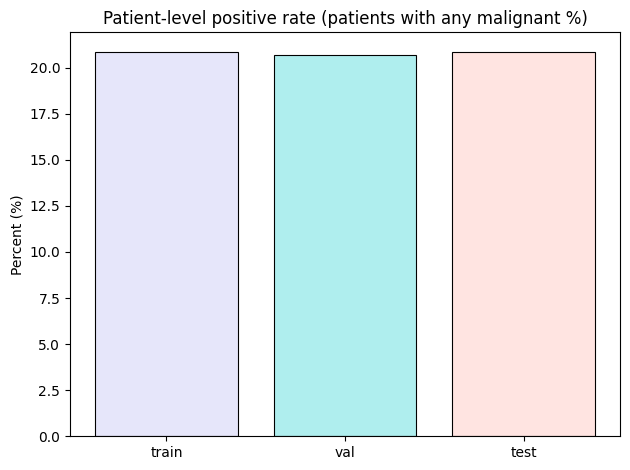

In [11]:
#verify Image-level prevalence (fraction of images with target=1)
img_prev = {
    "train": train_df["target"].mean(),
    "val":   val_df["target"].mean(),
    "test":  test_df["target"].mean(),
}

plt.figure()
plt.bar(list(img_prev.keys()), [100*v for v in img_prev.values()], color=["lightblue", "lightgreen", "moccasin"], edgecolor="black", linewidth=0.8)
plt.title("Image-level prevalence (malignant % of images)")
plt.ylabel("Percent (%)")
plt.tight_layout()
plt.show()

# Patient-level positive rate (fraction of patients with any target=1)
pt_prev = {
    "train": train_df.groupby("patient_id")["target"].max().mean(),
    "val":   val_df.groupby("patient_id")["target"].max().mean(),
    "test":  test_df.groupby("patient_id")["target"].max().mean(),
}

plt.figure()
plt.bar(list(pt_prev.keys()), [100*v for v in pt_prev.values()], color=["lavender", "paleturquoise", "mistyrose"], edgecolor="black", linewidth=0.8)
plt.title("Patient-level positive rate (patients with any malignant %)")
plt.ylabel("Percent (%)")
plt.tight_layout()
plt.show()


##Feature Engineering

In [12]:
#Age to categorical
age_bins = np.array([-1, 20, 30, 40, 50, 60, 70, 80, 200], dtype=float)
age_labels = ["0-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81+"]

#Not using rare sites to avoid overfitting
site_series = train_df_raw["anatom_site_general_challenge"].fillna("Unknown")
site_counts = site_series.value_counts()
keep_sites = set(site_counts[site_counts >= 200].index)

# Patient-level features learned from TRAIN
patient_groups = train_df_raw.groupby("patient_id")["target"]

patient_img_count_by_id = patient_groups.size().astype(int)
patient_pos_rate_by_id  = (patient_groups.sum() / patient_groups.size()).astype(float)
patient_any_pos_by_id   = patient_groups.max().astype(int)

default_patient_pos_rate = float(patient_pos_rate_by_id.mean()) if len(patient_pos_rate_by_id) else 0.0

logger.info(
    "FE fit: %s",
    info_dict({"keep_sites": len(keep_sites), "patients": int(patient_img_count_by_id.shape[0])}),
)

def apply_feature_engineering(frame):
    out = frame.copy()

    out["age_missing"] = out["age_approx"].isna().astype(int)
    out["sex_missing"] = out["sex"].isna().astype(int)
    out["site_missing"] = out["anatom_site_general_challenge"].isna().astype(int)

    out["age"] = pd.to_numeric(out["age_approx"], errors="coerce")
    out["age_bin"] = pd.cut(out["age"], bins=age_bins, labels=age_labels, include_lowest=True)
    out["age_bin"] = out["age_bin"].astype("object").fillna("Unknown")

    site_values = out["anatom_site_general_challenge"].astype("object").fillna("Unknown")
    out["site_grp"] = site_values.where(site_values.isin(keep_sites), other="Other")

    # create interactions
    sex_values = out["sex"].astype("object").fillna("Unknown")
    out["sex_x_site"] = sex_values + "__" + out["site_grp"].astype("object")
    out["agebin_x_site"] = out["age_bin"].astype("object") + "__" + out["site_grp"].astype("object")

    # patient-level features (map patient_id -> value)
    out["patient_img_count"] = out["patient_id"].map(patient_img_count_by_id).fillna(0).astype(int)
    out["patient_any_pos"] = out["patient_id"].map(patient_any_pos_by_id).fillna(0).astype(int)
    out["patient_pos_rate"] = (
        out["patient_id"].map(patient_pos_rate_by_id).fillna(default_patient_pos_rate).astype(float)
    )

    return out


# APPLY to raw splits (safe to rerun)
train_df = apply_feature_engineering(train_df_raw)
val_df   = apply_feature_engineering(val_df_raw)
test_df  = apply_feature_engineering(test_df_raw)

train_df.head()


INFO: FE fit: keep_sites=6 | patients=1315


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,filepath,age_missing,sex_missing,site_missing,age,age_bin,site_grp,sex_x_site,agebin_x_site,patient_img_count,patient_any_pos,patient_pos_rate
0,ISIC_4595555,IP_0036322,male,65.0,torso,nevus,benign,0,/content/datasets/isic2020_256/train-image/ima...,0,0,0,65.0,61-70,torso,male__torso,61-70__torso,5,0,0.0
1,ISIC_5775708,IP_0036322,male,70.0,torso,nevus,benign,0,/content/datasets/isic2020_256/train-image/ima...,0,0,0,70.0,61-70,torso,male__torso,61-70__torso,5,0,0.0
2,ISIC_6096977,IP_0036322,male,65.0,torso,nevus,benign,0,/content/datasets/isic2020_256/train-image/ima...,0,0,0,65.0,61-70,torso,male__torso,61-70__torso,5,0,0.0
3,ISIC_6163509,IP_0036322,male,65.0,torso,nevus,benign,0,/content/datasets/isic2020_256/train-image/ima...,0,0,0,65.0,61-70,torso,male__torso,61-70__torso,5,0,0.0
4,ISIC_6211801,IP_0036322,male,65.0,torso,nevus,benign,0,/content/datasets/isic2020_256/train-image/ima...,0,0,0,65.0,61-70,torso,male__torso,61-70__torso,5,0,0.0


##Baseline Model with metadata: LogisticRegression

In [26]:
target_col = "target"
categorical_cols = ["sex","age_bin","site_grp","sex_x_site","agebin_x_site"]
numeric_cols = ["age", "patient_img_count","patient_any_pos","patient_pos_rate",
                "age_missing","sex_missing","site_missing"]

feature_cols = categorical_cols + numeric_cols

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].astype(int).copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[target_col].astype(int).copy()

X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].astype(int).copy()

logger.info("LogisticRegression metadata baseline: %s", info_dict({"train_rows": len(train_df),"val_rows": len(val_df),"test_rows": len(test_df)}))
logger.info("Number of features: %s", info_dict({"n_features": len(feature_cols)}))
logger.info("image-level positive rates: %s", info_dict({"train": round(100 * float(y_train.mean()), 2),"val": round(100 * float(y_val.mean()), 2),
            "test_pos_pct": round(100 * float(y_test.mean()), 2)}))

#Preprocessor
preprocess = ColumnTransformer( transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", Pipeline(steps=[ ("imp", SimpleImputer(strategy="median")),("scaler", StandardScaler()),]), numeric_cols,),
        ], remainder="drop")

lr_model = Pipeline( steps=[
        ("prep", preprocess),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))])

lr_model.fit(X_train, y_train)

# Evaluate (PR-AUC)
p_val = lr_model.predict_proba(X_val)[:, 1]
p_test = lr_model.predict_proba(X_test)[:, 1]

val_pr_auc = float(average_precision_score(y_val, p_val))
test_pr_auc = float(average_precision_score(y_test, p_test))

logger.info("LogisticRegression metadata PR-AUC: %s", info_dict({"val_pr_auc": round(val_pr_auc, 5),"test_pr_auc": round(test_pr_auc, 5)}))


INFO: LogisticRegression metadata baseline: train_rows=21585 | val_rows=5170 | test_rows=6371
INFO: Number of features: n_features=12
INFO: image-level positive rates: train=1.8 | val=1.68 | test_pos_pct=1.71
INFO: LogisticRegression metadata PR-AUC: val_pr_auc=0.01966 | test_pr_auc=0.01719


Chosen threshold: 0.0003874183125481781


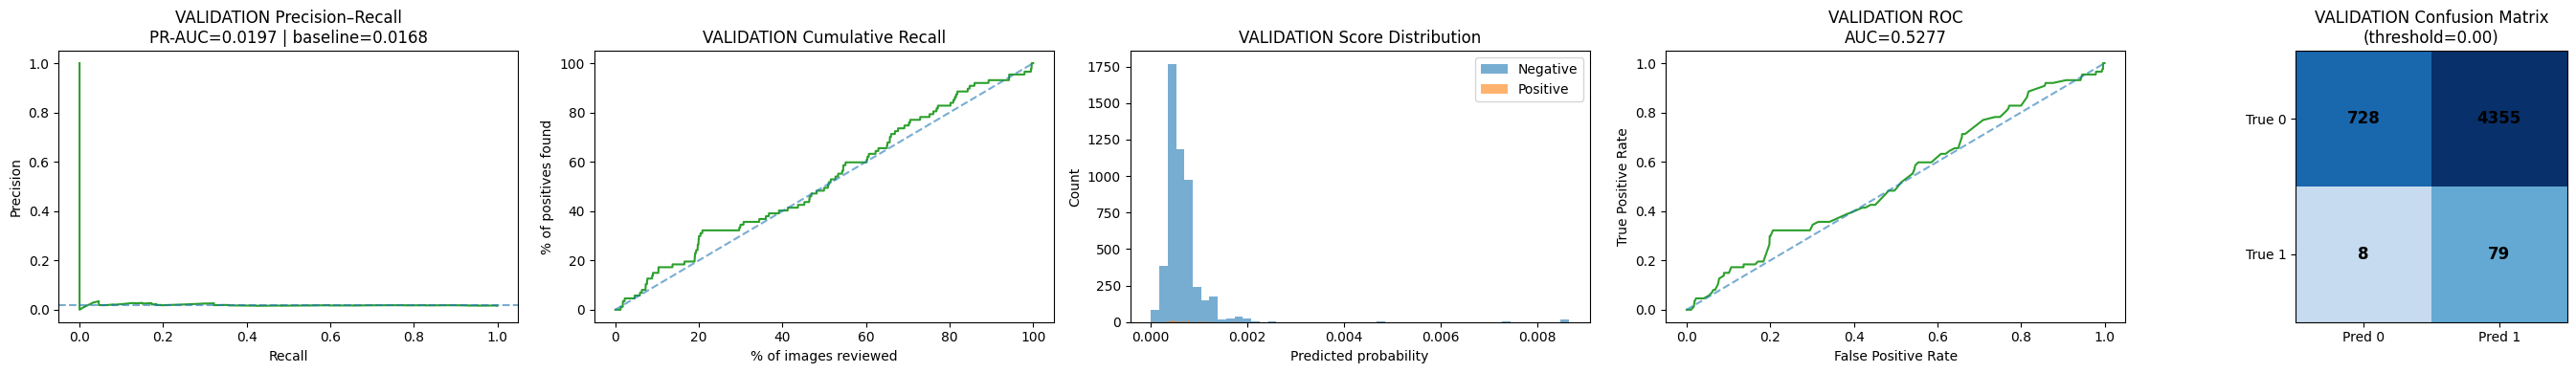

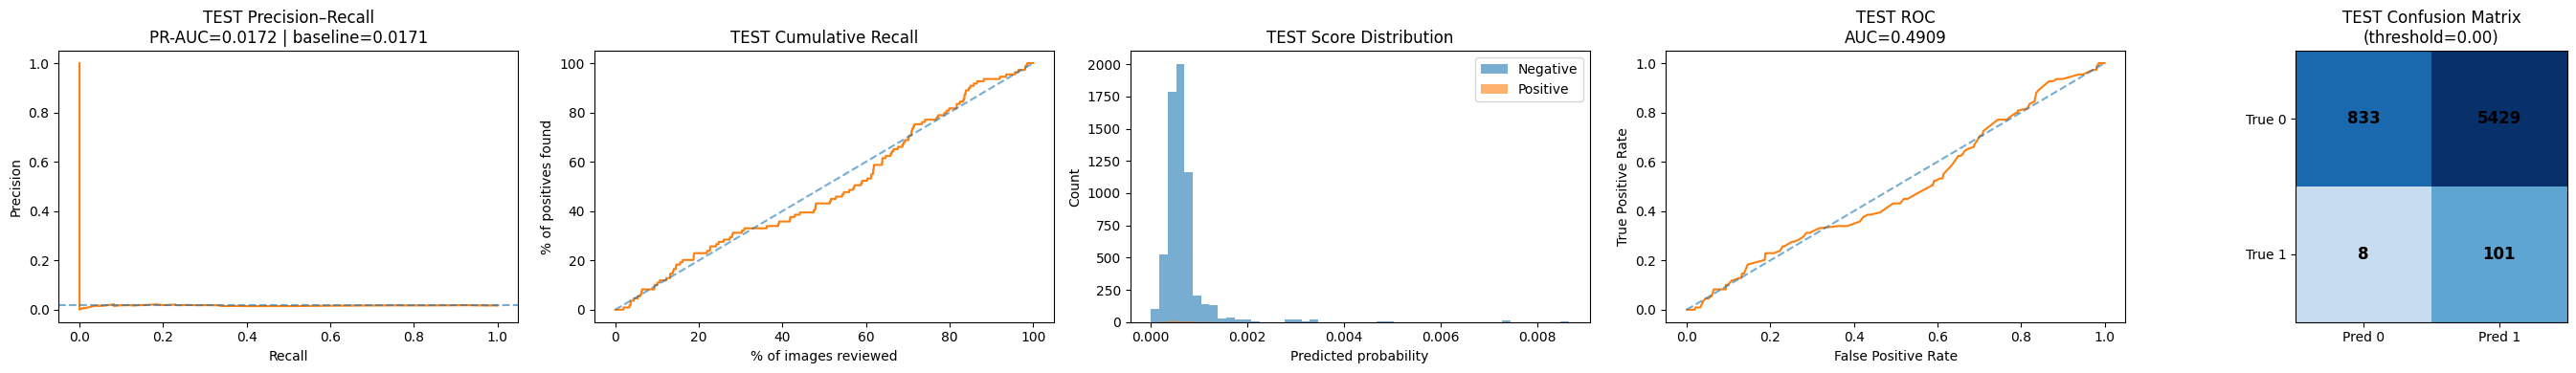

In [27]:
target_recall = 0.85
precision, recall, thresholds = precision_recall_curve(y_val, p_val)

# align thresholds with precision[1:], recall[1:]
precision_t, recall_t = precision[1:], recall[1:]
valid = np.where(recall_t >= target_recall)[0]

if len(valid) == 0:
    chosen_thresh = 0.5
else:
    i = valid[np.argmax(precision_t[valid])]
    chosen_thresh = float(thresholds[i])

print("Chosen threshold:", chosen_thresh)

plot_model_diagnostics(y_val, p_val, name="VALIDATION", color="tab:green", threshold=chosen_thresh)
plot_model_diagnostics(y_test, p_test, name="TEST", color="tab:orange", threshold=chosen_thresh)




##Baseline Model with metadata: LogisticRegression with Cross Validation and GridSearch

Class-weighted Logistic Regression (which up-weights the rare positive class to counter the 1–2% prevalence) is fitted and tuned with **5-fold GroupKFold** by patient_id to avoid same-patient leakage across folds. Then **GridSearch** explores **L1 vs L2 regularization** (sparsity/selective feature use vs smooth shrinkage) and **different regularization strengths** (C) to select the best setting by **cross-validated** PR-AUC.

In [28]:
target_col = "target"
categorical_cols = ["sex", "age_bin", "site_grp", "sex_x_site", "agebin_x_site"]
numeric_cols = [
    "age", "patient_img_count", "patient_any_pos", "patient_pos_rate",
    "age_missing", "sex_missing", "site_missing",
]
feature_cols = categorical_cols + numeric_cols

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].astype(int).copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[target_col].astype(int).copy()

X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].astype(int).copy()

logger.info("LogisticRegression metadata baseline: %s",
    info_dict({"train_rows": len(train_df), "val_rows": len(val_df), "test_rows": len(test_df)}))
logger.info("Number of features: %s", info_dict({"n_features": len(feature_cols)}))
logger.info("image-level positive rates: %s",info_dict({"train": round(100 * float(y_train.mean()), 2),
            "val": round(100 * float(y_val.mean()), 2),"test_pos_pct": round(100 * float(y_test.mean()), 2)}))

preprocess = ColumnTransformer(
    transformers= [("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
                  ("num", Pipeline( steps=[("imp", SimpleImputer(strategy="median")),("scaler", StandardScaler()),]),numeric_cols,),
                  ],
                  remainder="drop",
)

#CrossValidation and GridSearch
from sklearn.model_selection import GroupKFold, GridSearchCV

groups = train_df["patient_id"].values  # key: prevent same-patient leakage across folds

base_pipe = Pipeline(
    steps=[("prep", preprocess),
           ("model", LogisticRegression(max_iter=4000, class_weight="balanced")),
          ]
)

param_grid = {
    "model__solver": ["liblinear"],
    "model__penalty": ["l1", "l2"],
    "model__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

cv = GroupKFold(n_splits=5)

gs = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
)

gs.fit(X_train, y_train, groups=groups)

logger.info(
    "GridSearchCV best: %s",
    info_dict({"best_cv_pr_auc": round(float(gs.best_score_), 5), "best_params": gs.best_params_}),
)

lr_model = gs.best_estimator_

p_val = lr_model.predict_proba(X_val)[:, 1]
p_test = lr_model.predict_proba(X_test)[:, 1]

val_pr_auc = float(average_precision_score(y_val, p_val))
test_pr_auc = float(average_precision_score(y_test, p_test))

logger.info(
    "LogisticRegression metadata PR-AUC (tuned): %s",
    info_dict({"val_pr_auc": round(val_pr_auc, 5), "test_pr_auc": round(test_pr_auc, 5)}),
)


INFO: LogisticRegression metadata baseline: train_rows=21585 | val_rows=5170 | test_rows=6371
INFO: Number of features: n_features=12
INFO: image-level positive rates: train=1.8 | val=1.68 | test_pos_pct=1.71
INFO: GridSearchCV best: best_cv_pr_auc=0.31942 | best_params={'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
INFO: LogisticRegression metadata PR-AUC (tuned): val_pr_auc=0.02533 | test_pr_auc=0.01756


Chosen threshold: 0.03103481296470369
Model Diagnostics
Validation


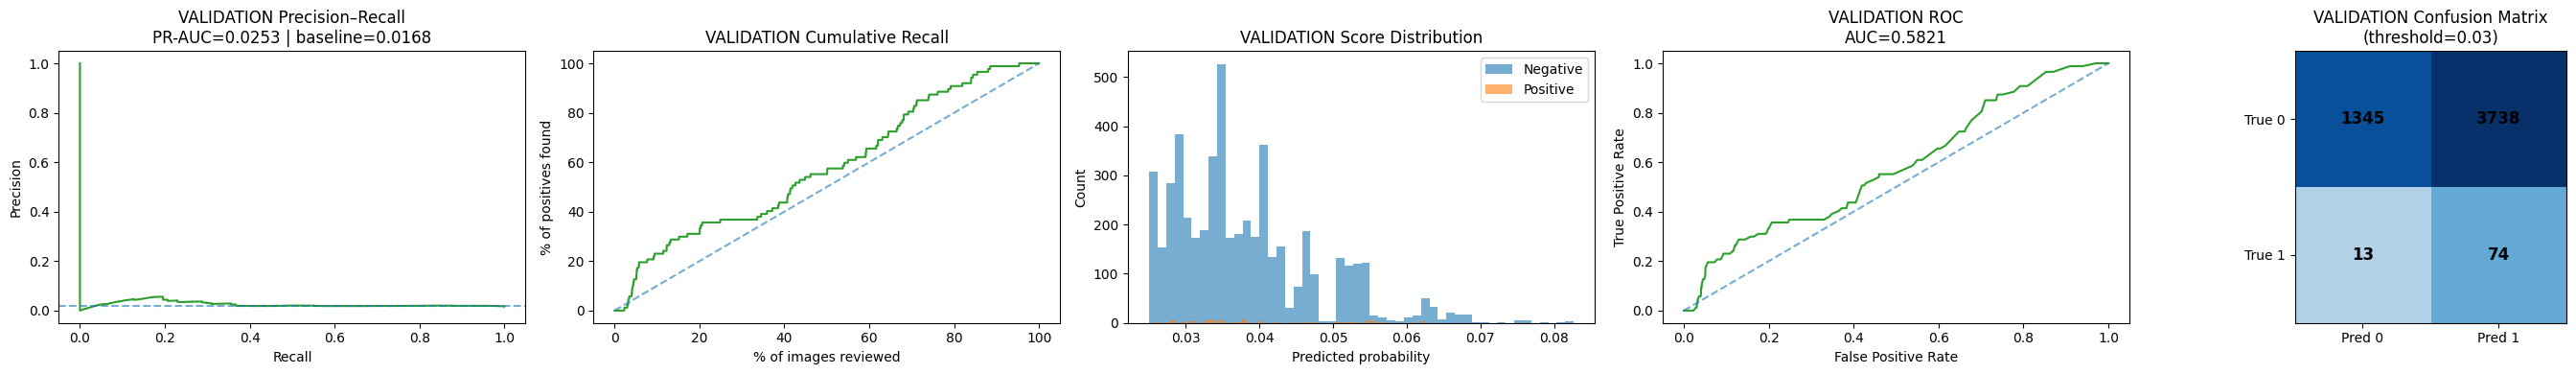

Test


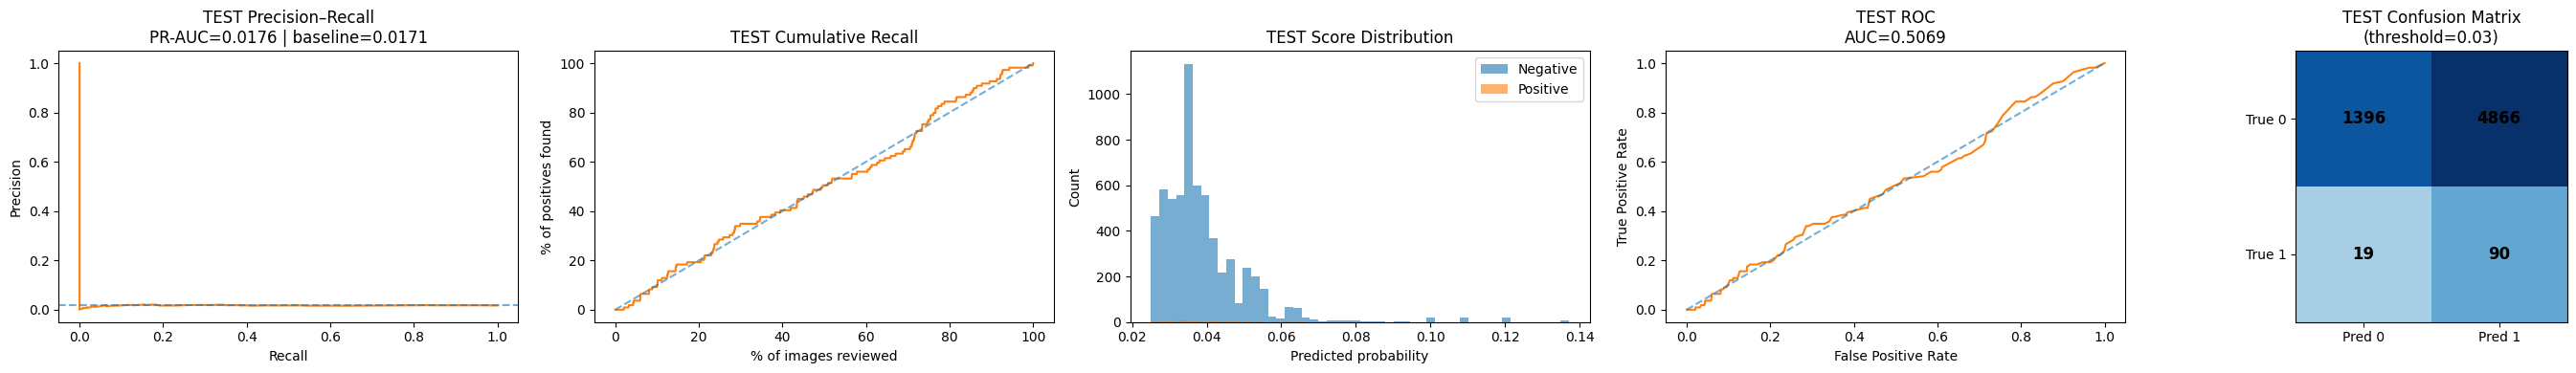

In [29]:
target_recall = 0.85
precision, recall, thresholds = precision_recall_curve(y_val, p_val)

# align thresholds with precision[1:], recall[1:]
precision_t, recall_t = precision[1:], recall[1:]
valid = np.where(recall_t >= target_recall)[0]

if len(valid) == 0:
    chosen_thresh = 0.5
else:
    i = valid[np.argmax(precision_t[valid])]
    chosen_thresh = float(thresholds[i])

print("Chosen threshold:", chosen_thresh)
print ("Model Diagnostics")
print ("Validation")
plot_model_diagnostics(y_val, p_val, name="VALIDATION", color="tab:green", threshold=chosen_thresh)
print ("Test")
plot_model_diagnostics(y_test, p_test, name="TEST", color="tab:orange", threshold=chosen_thresh)


##Baseline Model with metadata: Gradient Boosted Decision Trees (GBDT) - HistGradientBoostingClassifier

Trained a metadata-only **HistGradientBoostingClassifier** with one-hot encoded categorical features and median-imputed numeric features. I used HistGradientBoostingClassifier because **Gradient Boosted Decision Trees** can capture non linear relationships and feature interactions that logistic regression often misses.

In [30]:
X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].astype(int).copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[target_col].astype(int).copy()

X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].astype(int).copy()

preprocess_tree = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", SimpleImputer(strategy="median"), numeric_cols)
    ],
    remainder="drop"
)

tree_model = Pipeline(
    steps=[
        ("prep", preprocess_tree),
        ("model", HistGradientBoostingClassifier(random_state=SEED), )
    ]
)

tree_model.fit(X_train, y_train)

# Evaluate (PR-AUC)
p_val_tree = tree_model.predict_proba(X_val)[:, 1]
p_test_tree = tree_model.predict_proba(X_test)[:, 1]

val_pr_auc_tree = float(average_precision_score(y_val, p_val_tree))
test_pr_auc_tree = float(average_precision_score(y_test, p_test_tree))

logger.info(
    "HistGradientBoosting metadata PR-AUC: %s",
    info_dict({"val_pr_auc": round(val_pr_auc_tree, 5), "test_pr_auc": round(test_pr_auc_tree, 5)}),
)


INFO: HistGradientBoosting metadata PR-AUC: val_pr_auc=0.01839 | test_pr_auc=0.01783


Chosen threshold: 0.03103481296470369
Model Diagnostics
Validation


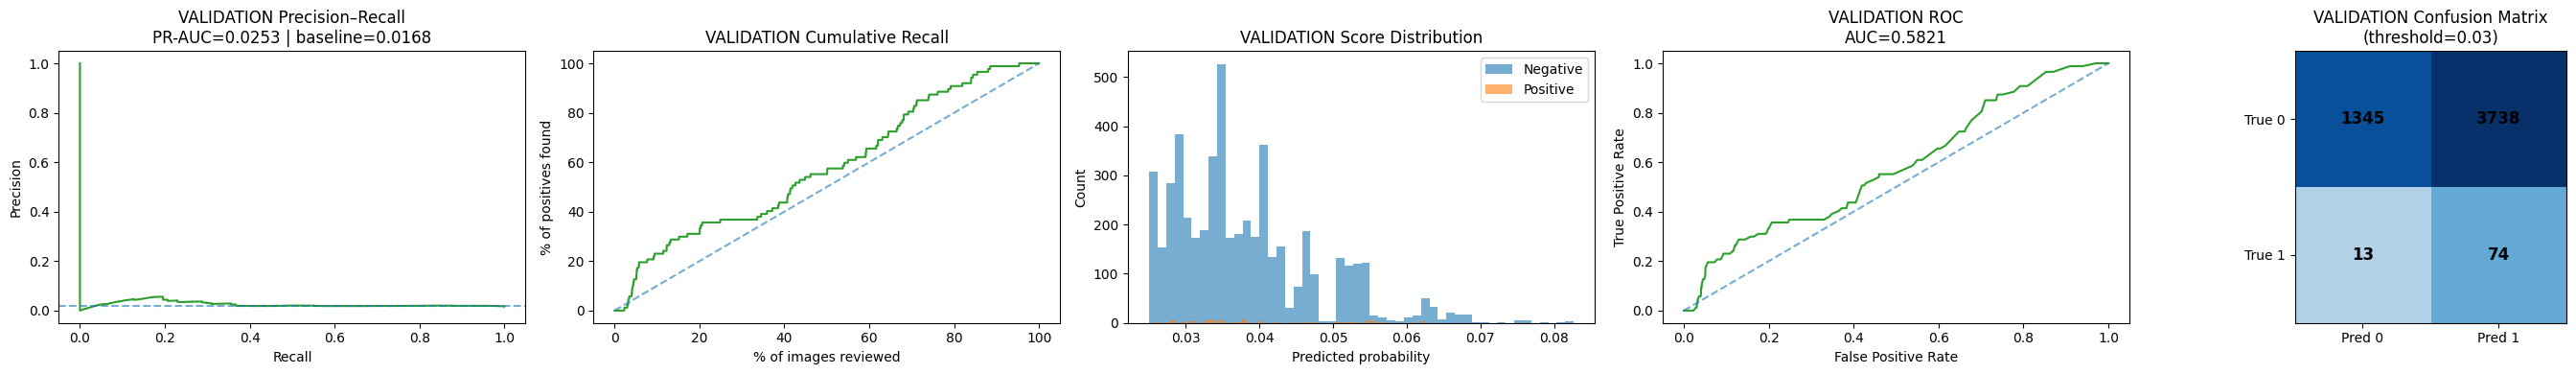

Test


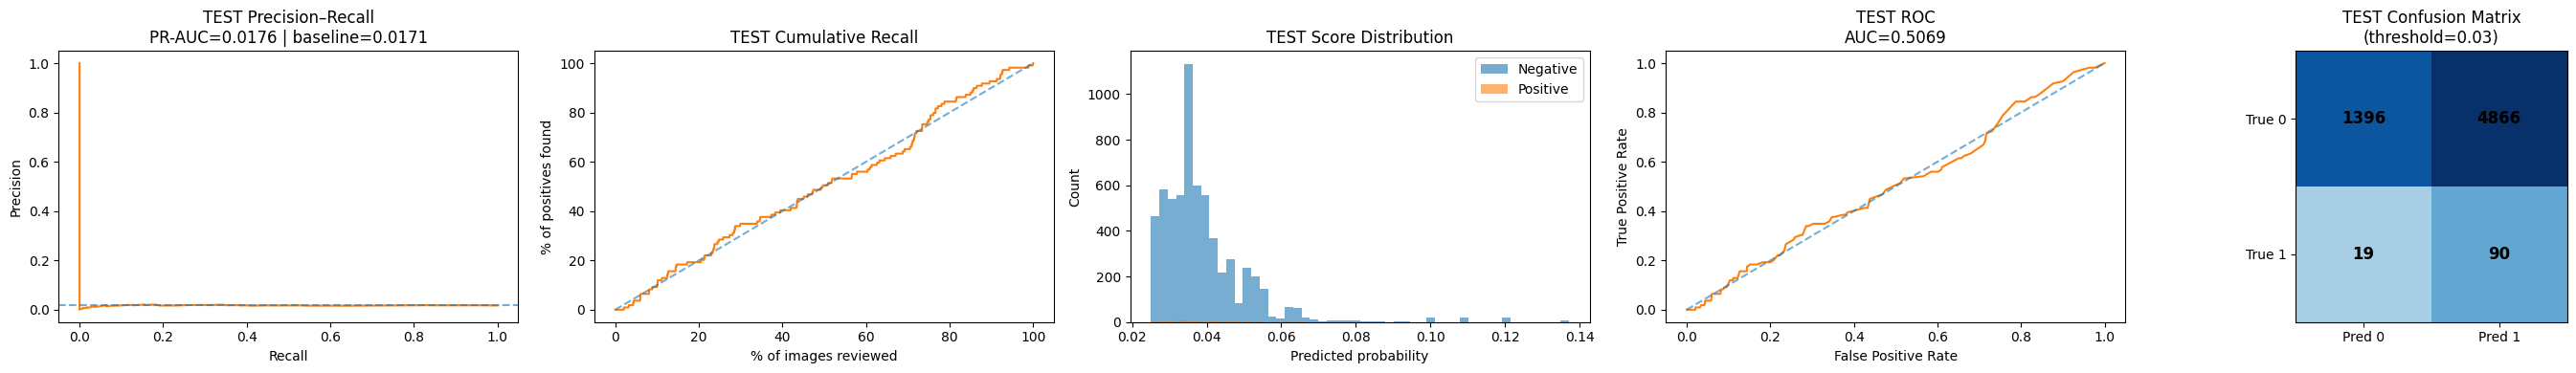

In [31]:
target_recall = 0.85
precision, recall, thresholds = precision_recall_curve(y_val, p_val)

# align thresholds with precision[1:], recall[1:]
precision_t, recall_t = precision[1:], recall[1:]
valid = np.where(recall_t >= target_recall)[0]

if len(valid) == 0:
    chosen_thresh = 0.5
else:
    i = valid[np.argmax(precision_t[valid])]
    chosen_thresh = float(thresholds[i])

print("Chosen threshold:", chosen_thresh)
print ("Model Diagnostics")
print ("Validation")
plot_model_diagnostics(y_val, p_val, name="VALIDATION", color="tab:green", threshold=chosen_thresh)
print ("Test")
plot_model_diagnostics(y_test, p_test, name="TEST", color="tab:orange", threshold=chosen_thresh)


##Convolutional Neural Network (CNN) Model - EfficientNet-B0
I chose it because it is widely used for image classification, often outperforming much larger models like ResNet with significantly fewer parameters. Pretrained on ImageNet dataset images features that transfer well, so head-only training is a reliable.

Training strategy: Freeze backbone and train only classifier head.

Used (torchvision) for light augmentation (flip and small rotation).

Imbalance handling: Used pos_weight = neg/pos inside **BCEWithLogitsLoss** to upweight positives (malignant).

Used **AdamW** optimizer during training to update the model’s trainable weights and to reduce the **loss**.


INFO: Train prevalence (%): 1.80


device: cuda


INFO: Head-only training setup: epochs=10 | patience=2 | batch_size=32 | pos_weight=54.63
INFO: epoch=1 | train_loss=1.1565 | val_pr=0.0825 | val_roc=0.8242
INFO: Saved new best checkpoint: effb0_head_only_best.pt
INFO: epoch=2 | train_loss=1.0139 | val_pr=0.0834 | val_roc=0.8318
INFO: Saved new best checkpoint: effb0_head_only_best.pt
INFO: epoch=3 | train_loss=0.9817 | val_pr=0.0776 | val_roc=0.8241
INFO: epoch=4 | train_loss=0.9781 | val_pr=0.0903 | val_roc=0.8289
INFO: Saved new best checkpoint: effb0_head_only_best.pt
INFO: epoch=5 | train_loss=0.9476 | val_pr=0.0832 | val_roc=0.8232
INFO: epoch=6 | train_loss=0.9416 | val_pr=0.0834 | val_roc=0.8413
INFO: Early stopping (patience=2).


Chosen threshold (VAL, recall≥0.85): 0.504164
Model Diagnostics
Validation


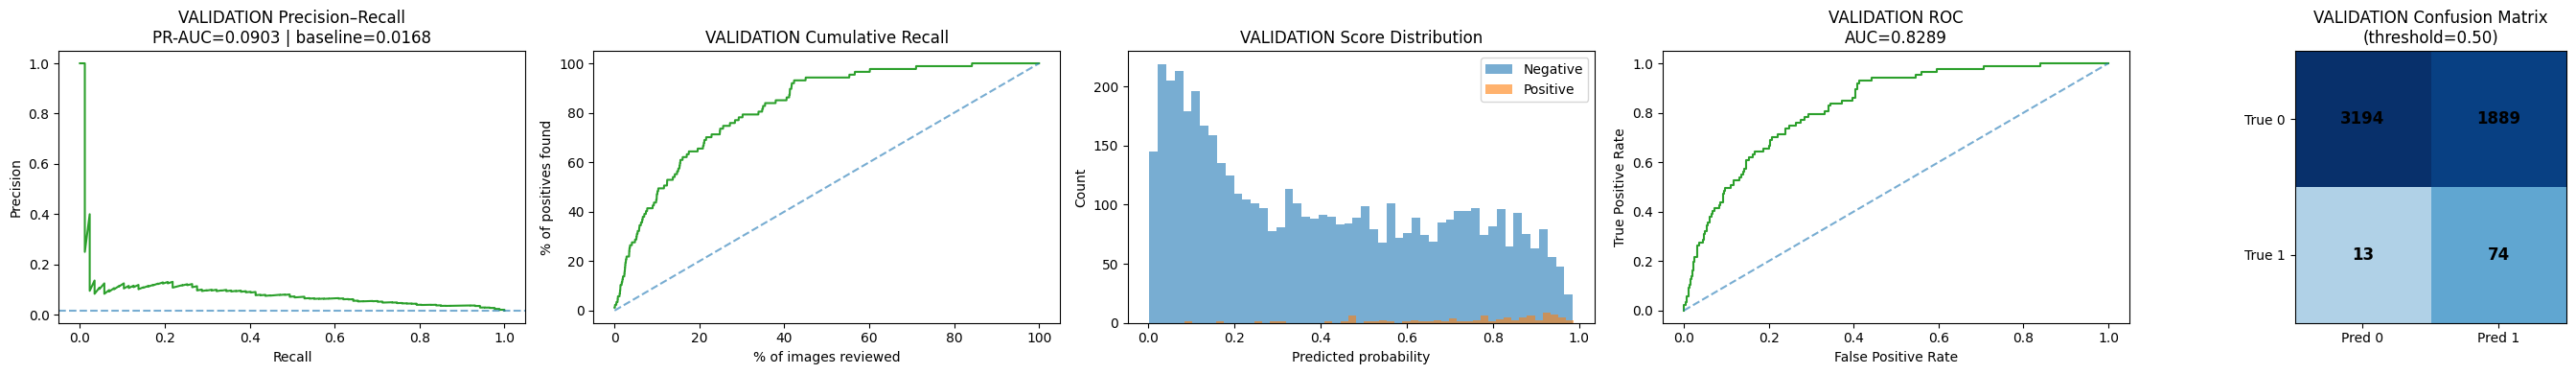

Test


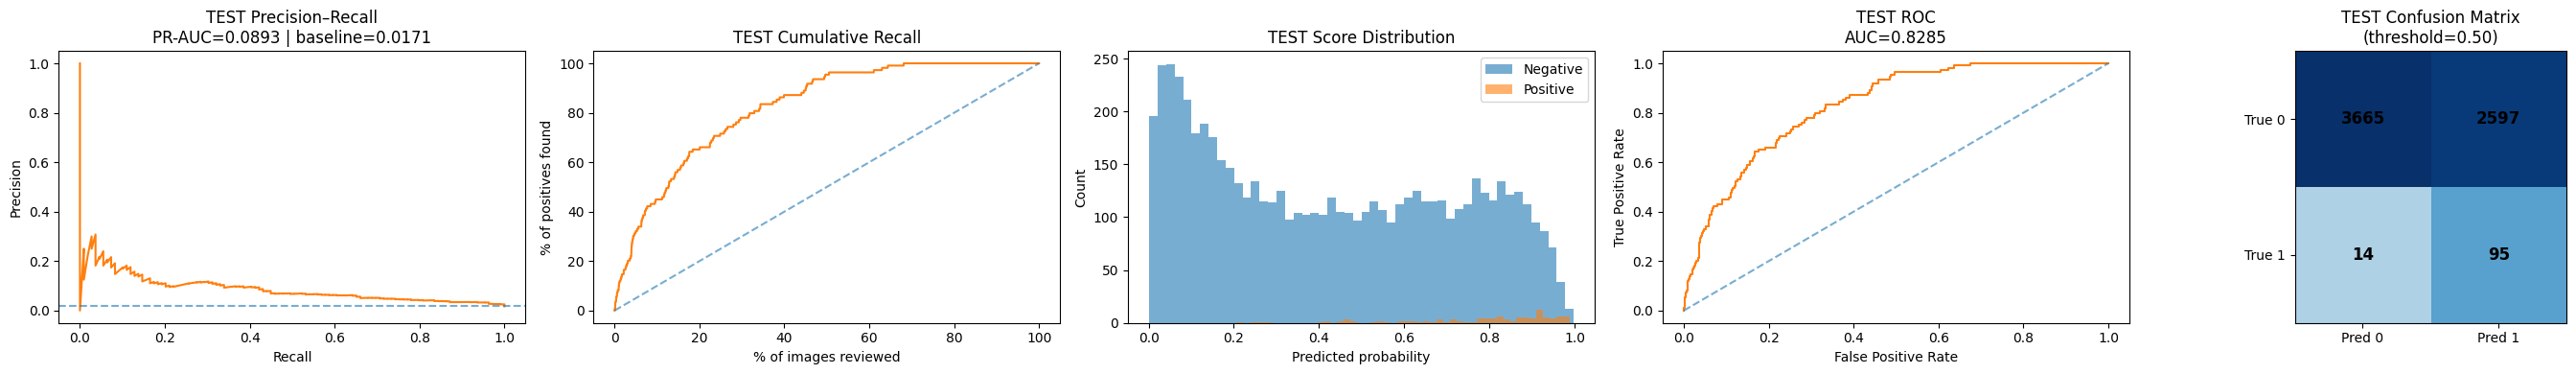

INFO: Head-only best checkpoint results: best_val_pr=0.09029 | test_pr=0.08929 | test_roc=0.82852


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
PATIENCE = 2

logger.info("Train prevalence (%%): %.2f", 100 * float(train_df["target"].mean()))

train_tfms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

eval_tfms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

class ISICDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filepath"]

        # Close file handle cleanly
        with Image.open(img_path) as im:
            img = im.convert("RGB")

        x = self.tfms(img)
        y = torch.tensor(float(row["target"]), dtype=torch.float32)
        return x, y


train_loader = DataLoader(ISICDataset(train_df, train_tfms), batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=(device.type == "cuda"))
val_loader   = DataLoader(ISICDataset(val_df, eval_tfms),batch_size=BATCH_SIZE,shuffle=False,num_workers=0,pin_memory=(device.type == "cuda"))
test_loader  = DataLoader(ISICDataset(test_df, eval_tfms),batch_size=BATCH_SIZE,shuffle=False,num_workers=0,pin_memory=(device.type == "cuda"))

# Model
def build_effnet_b0(pretrained=True):
    try:
        weights = models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
        model = models.efficientnet_b0(weights=weights)
    except AttributeError:
        model = models.efficientnet_b0(pretrained=pretrained)

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 1)  # binary logits
    return model.to(device)

model = build_effnet_b0(pretrained=True)

# Freeze model.features which is the EfficientNet backbone
for p in model.features.parameters():
    p.requires_grad = False
#Train the final classification head
for p in model.classifier.parameters():
    p.requires_grad = True

# Loss penalizes mistakes on malignant cases more than benign
# The model treats malignant as more important, which helps as malignants are rare in the dataset
y_train_np = train_df["target"].values.astype(np.float32)
pos = float(y_train_np.sum())
neg = float(len(y_train_np) - pos)
pos_weight = None if pos == 0 else torch.tensor([neg / pos], dtype=torch.float32, device=device)

logger.info(
    "Head-only training setup: %s", info_dict({"epochs": EPOCHS,"patience": PATIENCE,"batch_size": BATCH_SIZE,
            "pos_weight": None if pos_weight is None else round(float(pos_weight.item()), 2)
        }
    )
)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=1e-4)

def eval_model(model, loader):
    model.eval()
    y_list = []
    p_list = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            probs = torch.sigmoid(model(x).squeeze(1)).cpu().numpy()
            p_list.append(probs)
            y_list.append(y.numpy())

    y_true = np.concatenate(y_list)
    y_prob = np.concatenate(p_list)
    return (
        float(average_precision_score(y_true, y_prob)),
        float(roc_auc_score(y_true, y_prob)),
    )

# Train loop with early stopping
best_val_pr = -1.0
bad_epochs = 0
ckpt_path = artifact_output_directory / "effb0_head_only_best.pt"

for epoch in range(1, EPOCHS + 1):
    model.train()
    losses = []

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(x).squeeze(1)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(float(loss.detach().cpu().item()))

    train_loss = float(np.mean(losses)) if losses else float("nan")
    val_pr, val_roc = eval_model(model, val_loader)

    logger.info("epoch=%d | train_loss=%.4f | val_pr=%.4f | val_roc=%.4f",epoch,train_loss,val_pr,val_roc)

    if val_pr > best_val_pr:
        best_val_pr = val_pr
        bad_epochs = 0
        torch.save({"model_state": model.state_dict(), "img_size": IMG_SIZE}, str(ckpt_path))
        logger.info("Saved new best checkpoint: %s", ckpt_path.name)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            logger.info("Early stopping (patience=%d).", PATIENCE)
            break

# load the best saved model weights, evaluate that model on the test set
ckpt = torch.load(str(ckpt_path), map_location=device)
model.load_state_dict(ckpt["model_state"])

#plot
def collect_probs_from_loader(model, loader):
    model.eval()
    y_list, p_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            p = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
            y_list.append(y.detach().cpu().numpy())
            p_list.append(p)
    y_true = np.concatenate(y_list).astype(int)
    p_prob = np.concatenate(p_list)
    return y_true, p_prob

y_val,  p_val  = collect_probs_from_loader(model, val_loader)
y_test, p_test = collect_probs_from_loader(model, test_loader)

target_recall = 0.85
precision, recall, thresholds = precision_recall_curve(y_val, p_val)

# thresholds aligns with precision[1:], recall[1:]
precision_t = precision[1:]
recall_t = recall[1:]

valid = np.where(recall_t >= target_recall)[0]
if len(valid) == 0:
    chosen_thresh = 0.5
else:
    i = valid[np.argmax(precision_t[valid])]
    chosen_thresh = float(thresholds[i])

print(f"Chosen threshold (VAL, recall≥{target_recall:.2f}): {chosen_thresh:.6f}")

print("Model Diagnostics")
print("Validation")
plot_model_diagnostics(y_val, p_val, name="VALIDATION", color="tab:green", threshold=chosen_thresh)

print("Test")
plot_model_diagnostics(y_test, p_test, name="TEST", color="tab:orange", threshold=chosen_thresh)


test_pr, test_roc = eval_model(model, test_loader)
logger.info ("Head-only best checkpoint results: %s",info_dict({"best_val_pr": round(best_val_pr, 5),
             "test_pr": round(test_pr, 5), "test_roc": round(test_roc, 5)}))

gc.collect()
if device.type == "cuda":
    torch.cuda.empty_cache()


##Convolutional Neural Network (CNN) Model - EfficientNet-B0 with image augmentaion using **Albumentations**
The training pipeline uses **Albumentations** to apply a richer and more diverse set of image augmentations.
Each training image is first resized to a fixed input size. It is then randomly flipped horizontally and vertically to improve invariance to orientation. Next, an affine transformation is applied, which includes small random translations, scaling, and rotations of up to ±20 degrees to increase geometric robustness.

After the geometric transformations, color and illumination variations are introduced through random brightness and contrast adjustments, hue and saturation shifts, and gamma corrections. To further improve robustness to image quality variations common in real-world data, the pipeline occasionally applies mild blurring or Gaussian noise. Finally, the image is normalized using ImageNet mean and standard deviation and converted into a PyTorch tensor using ToTensorV2

INFO: Train prevalence (%): 1.80
INFO: Head-only training setup: epochs=10 | patience=2 | batch_size=32 | pos_weight=54.63


device: cuda


INFO: epoch=1 | train_loss=1.1936 | val_pr=0.0875 | val_roc=0.8293
INFO: Saved new best checkpoint: effb0_head_only_best_albu.pt
INFO: epoch=2 | train_loss=1.1157 | val_pr=0.0747 | val_roc=0.8292
INFO: epoch=3 | train_loss=1.0889 | val_pr=0.0876 | val_roc=0.8473
INFO: Saved new best checkpoint: effb0_head_only_best_albu.pt
INFO: epoch=4 | train_loss=1.0736 | val_pr=0.0911 | val_roc=0.8410
INFO: Saved new best checkpoint: effb0_head_only_best_albu.pt
INFO: epoch=5 | train_loss=1.0312 | val_pr=0.0855 | val_roc=0.8453
INFO: epoch=6 | train_loss=1.0386 | val_pr=0.0915 | val_roc=0.8495
INFO: Saved new best checkpoint: effb0_head_only_best_albu.pt
INFO: epoch=7 | train_loss=1.0486 | val_pr=0.0934 | val_roc=0.8522
INFO: Saved new best checkpoint: effb0_head_only_best_albu.pt
INFO: epoch=8 | train_loss=1.0602 | val_pr=0.0863 | val_roc=0.8449
INFO: epoch=9 | train_loss=1.0452 | val_pr=0.0934 | val_roc=0.8389
INFO: Early stopping (patience=2).


Chosen threshold (VAL, recall≥0.85): 0.384426
Model Diagnostics
Validation


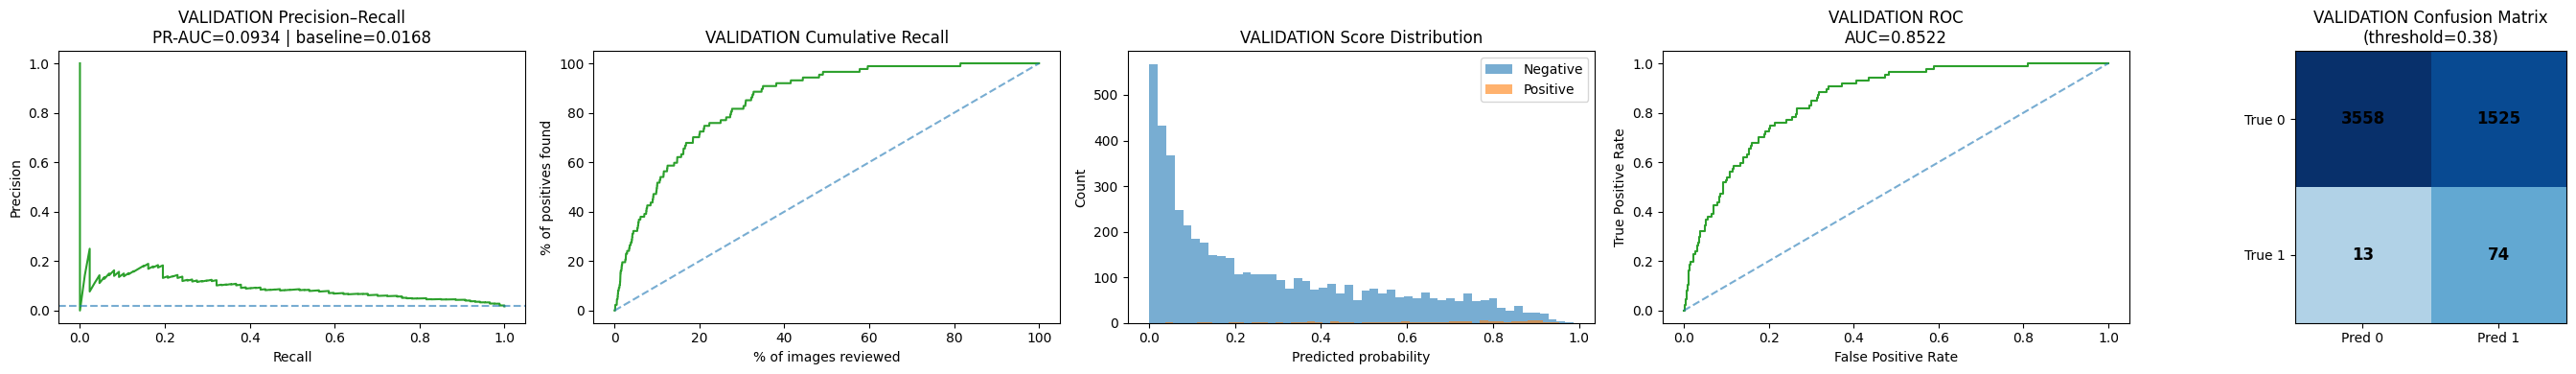

Test


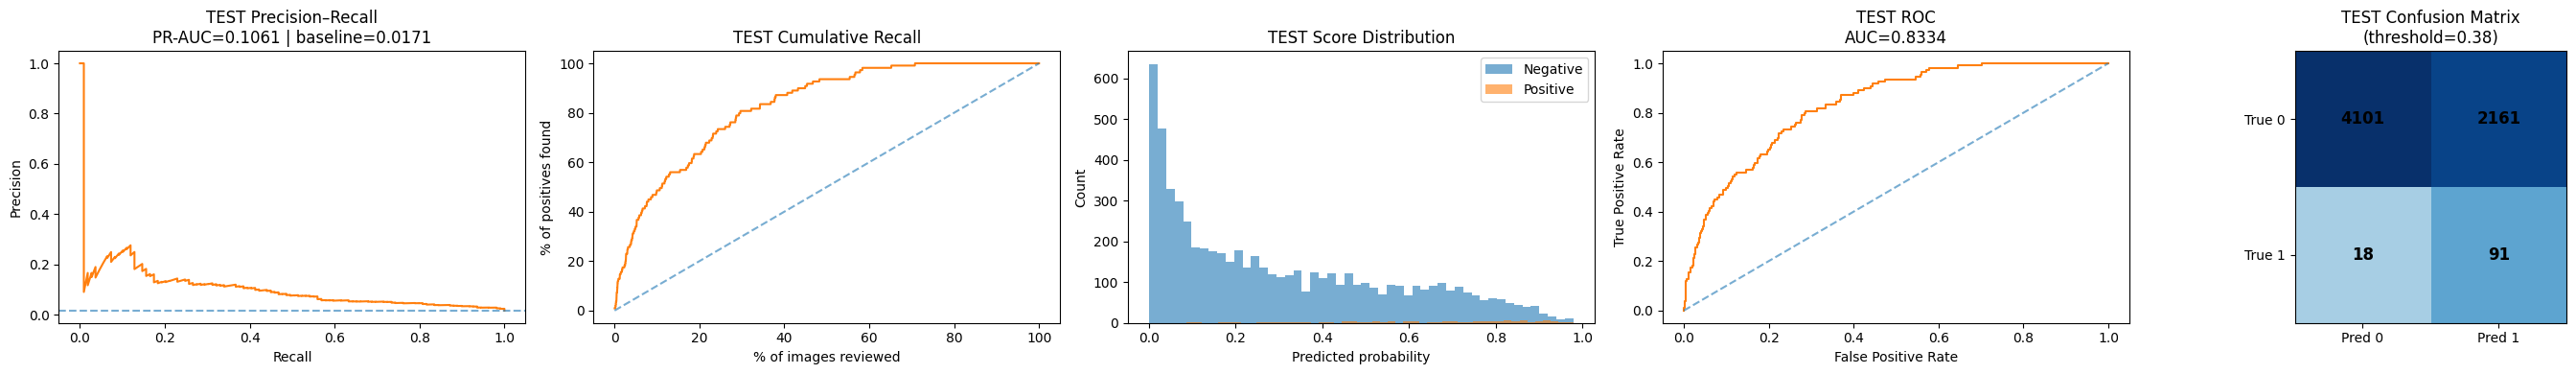

INFO: Head-only best checkpoint results: best_val_pr=0.09341 | test_pr=0.10609 | test_roc=0.8334


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
PATIENCE = 2

logger.info("Train prevalence (%%): %.2f", 100 * float(train_df["target"].mean()))

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),

        # geometry
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            scale=(0.90, 1.10),
            rotate=(-20, 20),
            p=0.9,
        ),

        # color / lighting
        A.RandomBrightnessContrast(p=0.6),
        A.HueSaturationValue(p=0.4),
        A.RandomGamma(p=0.3),

        # mild robustness (low-res dataset)
        A.OneOf(
            [
                A.GaussianBlur(blur_limit=3, p=1.0),
                A.MotionBlur(blur_limit=3, p=1.0),
                A.GaussNoise(std_range=(0.02, 0.08), p=1.0),
            ],
            p=0.3,
        ),

        # model expects normalized tensors
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

eval_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

class ISICDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filepath"]

        with Image.open(img_path) as im:
            img = np.array(im.convert("RGB"))

        x = self.tfms(image=img)["image"]  # torch.Tensor CxHxW
        y = torch.tensor(row["target"], dtype=torch.float32)
        return x, y

train_loader = DataLoader(
    ISICDataset(train_df, train_tfms),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)
val_loader = DataLoader(
    ISICDataset(val_df, eval_tfms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)
test_loader = DataLoader(
    ISICDataset(test_df, eval_tfms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

# Model
def build_effnet_b0(pretrained=True):
    try:
        weights = models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
        model = models.efficientnet_b0(weights=weights)
    except AttributeError:
        model = models.efficientnet_b0(pretrained=pretrained)

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 1)
    return model.to(device)

model = build_effnet_b0(pretrained=True)

# Freeze backbone, train head
for p in model.features.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True


# Imbalance handling (pos_weight)
y_train_np = train_df["target"].values.astype(np.float32)
pos = float(y_train_np.sum())
neg = float(len(y_train_np) - pos)
pos_weight = None if pos == 0 else torch.tensor([neg / pos], dtype=torch.float32, device=device)

logger.info(
    "Head-only training setup: %s",
    info_dict(
        {
            "epochs": EPOCHS,
            "patience": PATIENCE,
            "batch_size": BATCH_SIZE,
            "pos_weight": None if pos_weight is None else round(float(pos_weight.item()), 2),
        }
    ),
)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=1e-4)

def eval_model(model, loader):
    model.eval()
    y_list, p_list = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            probs = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
            p_list.append(probs)
            y_list.append(y.numpy())

    y_true = np.concatenate(y_list)
    y_prob = np.concatenate(p_list)
    return float(average_precision_score(y_true, y_prob)), float(roc_auc_score(y_true, y_prob))

# Train loop with early stopping
best_val_pr = -1.0
bad_epochs = 0
ckpt_path = artifact_output_directory / "effb0_head_only_best_albu.pt"

for epoch in range(1, EPOCHS + 1):
    model.train()
    losses = []

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)
        logits = model(x).squeeze(1)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(float(loss.detach().cpu().item()))

    train_loss = float(np.mean(losses)) if losses else float("nan")
    val_pr, val_roc = eval_model(model, val_loader)

    logger.info("epoch=%d | train_loss=%.4f | val_pr=%.4f | val_roc=%.4f", epoch, train_loss, val_pr, val_roc)

    if val_pr > best_val_pr:
        best_val_pr = val_pr
        bad_epochs = 0
        torch.save({"model_state": model.state_dict(), "img_size": IMG_SIZE}, str(ckpt_path))
        logger.info("Saved new best checkpoint: %s", ckpt_path.name)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            logger.info("Early stopping (patience=%d).", PATIENCE)
            break


# Load best model
ckpt = torch.load(str(ckpt_path), map_location=device)
model.load_state_dict(ckpt["model_state"])

#plot
def collect_probs_from_loader(model, loader):
    model.eval()
    y_list, p_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            p = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
            y_list.append(y.detach().cpu().numpy())
            p_list.append(p)
    y_true = np.concatenate(y_list).astype(int)
    p_prob = np.concatenate(p_list)
    return y_true, p_prob

y_val,  p_val  = collect_probs_from_loader(model, val_loader)
y_test, p_test = collect_probs_from_loader(model, test_loader)

target_recall = 0.85
precision, recall, thresholds = precision_recall_curve(y_val, p_val)

# thresholds aligns with precision[1:], recall[1:]
precision_t = precision[1:]
recall_t = recall[1:]

valid = np.where(recall_t >= target_recall)[0]
if len(valid) == 0:
    chosen_thresh = 0.5
else:
    i = valid[np.argmax(precision_t[valid])]
    chosen_thresh = float(thresholds[i])

print(f"Chosen threshold (VAL, recall≥{target_recall:.2f}): {chosen_thresh:.6f}")

print("Model Diagnostics")
print("Validation")
plot_model_diagnostics(y_val, p_val, name="VALIDATION", color="tab:green", threshold=chosen_thresh)

print("Test")
plot_model_diagnostics(y_test, p_test, name="TEST", color="tab:orange", threshold=chosen_thresh)

test_pr, test_roc = eval_model(model, test_loader)
logger.info(
    "Head-only best checkpoint results: %s",
    info_dict({"best_val_pr": round(best_val_pr, 5), "test_pr": round(test_pr, 5), "test_roc": round(test_roc, 5)}),
)

gc.collect()
if device.type == "cuda":
    torch.cuda.empty_cache()



##Convolutional Neural Network (CNN) Model EfficientNet-B0 classifier using a two-stage fine-tuning approach with Albumentations-based image augmentation

Images are resized, augmented, normalized with ImageNet statistics, and converted to tensors, while class imbalance is handled using a weighted binary cross-entropy loss.
In Stage 1, the pretrained backbone is frozen and only the classifier head is trained, with validation PR-AUC used for early stopping and checkpoint selection.
In Stage 2, the best Stage 1 model is reloaded and only the final EfficientNet block plus the classifier head are fine-tuned using a lower learning rate for the backbone.
The final model is evaluated on the test set using PR-AUC and ROC-AUC.

INFO: Train prevalence (%): 1.80
INFO: pos_weight: 54.63


device: cuda


INFO: S1 epoch=1 | loss=1.2059 | val_pr=0.07715 | val_roc=0.8294
INFO: S1 saved best: effb0_stage1_head_only_best.pt
INFO: S1 epoch=2 | loss=1.1305 | val_pr=0.06757 | val_roc=0.8342
INFO: S1 epoch=3 | loss=1.0753 | val_pr=0.07774 | val_roc=0.8327
INFO: S1 saved best: effb0_stage1_head_only_best.pt
INFO: S1 epoch=4 | loss=1.0794 | val_pr=0.07738 | val_roc=0.8383
INFO: S1 epoch=5 | loss=1.0926 | val_pr=0.07217 | val_roc=0.8294
INFO: S1 early stopping (patience=2)
INFO: Stage 1 best_val_pr=0.07774 | ckpt=effb0_stage1_head_only_best.pt
INFO: S2 epoch=1 | loss=1.0857 | val_pr=0.07750 | val_roc=0.8357
INFO: S2 saved best: effb0_stage2_lastblock_best.pt
INFO: S2 epoch=2 | loss=1.0700 | val_pr=0.07360 | val_roc=0.8168
INFO: S2 epoch=3 | loss=1.0488 | val_pr=0.08694 | val_roc=0.8288
INFO: S2 saved best: effb0_stage2_lastblock_best.pt
INFO: S2 epoch=4 | loss=1.0452 | val_pr=0.10043 | val_roc=0.8561
INFO: S2 saved best: effb0_stage2_lastblock_best.pt
INFO: S2 epoch=5 | loss=1.0203 | val_pr=0.0847

Chosen threshold (VAL, recall≥0.85): 0.316690
Model Diagnostics
Validation


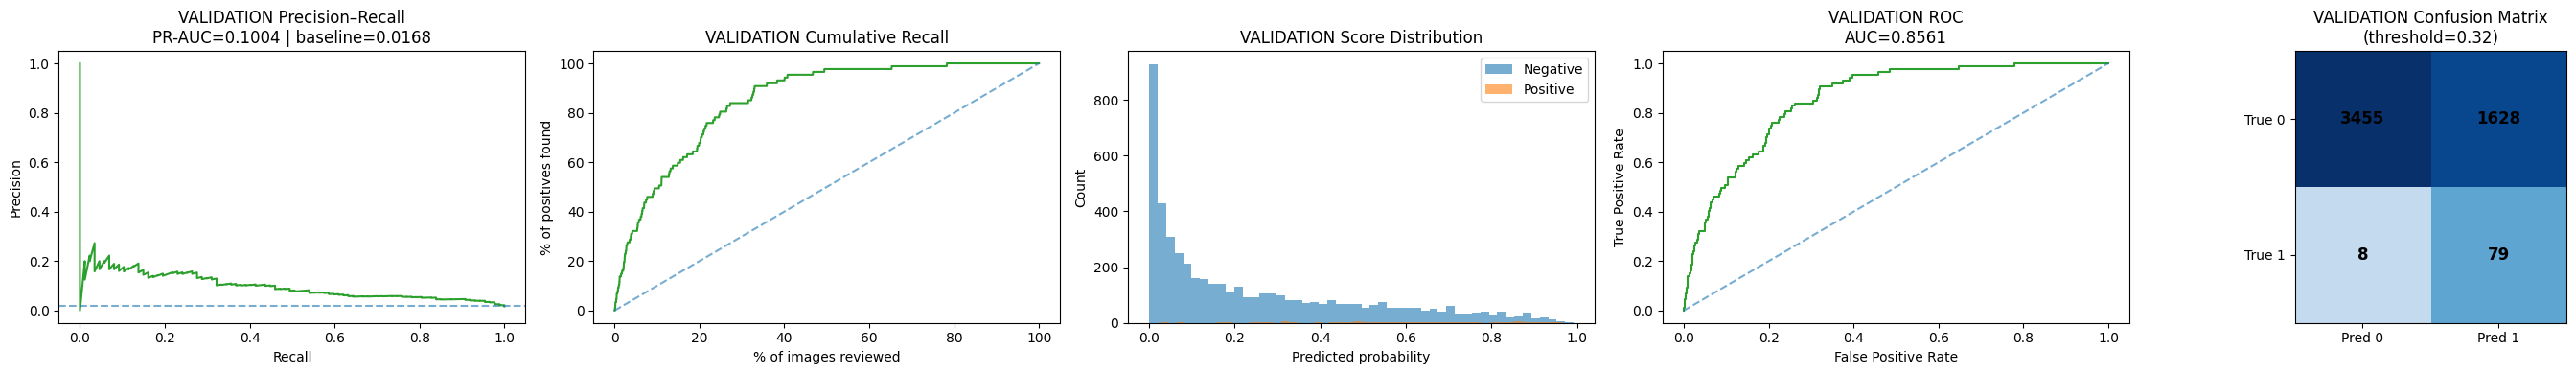

Test


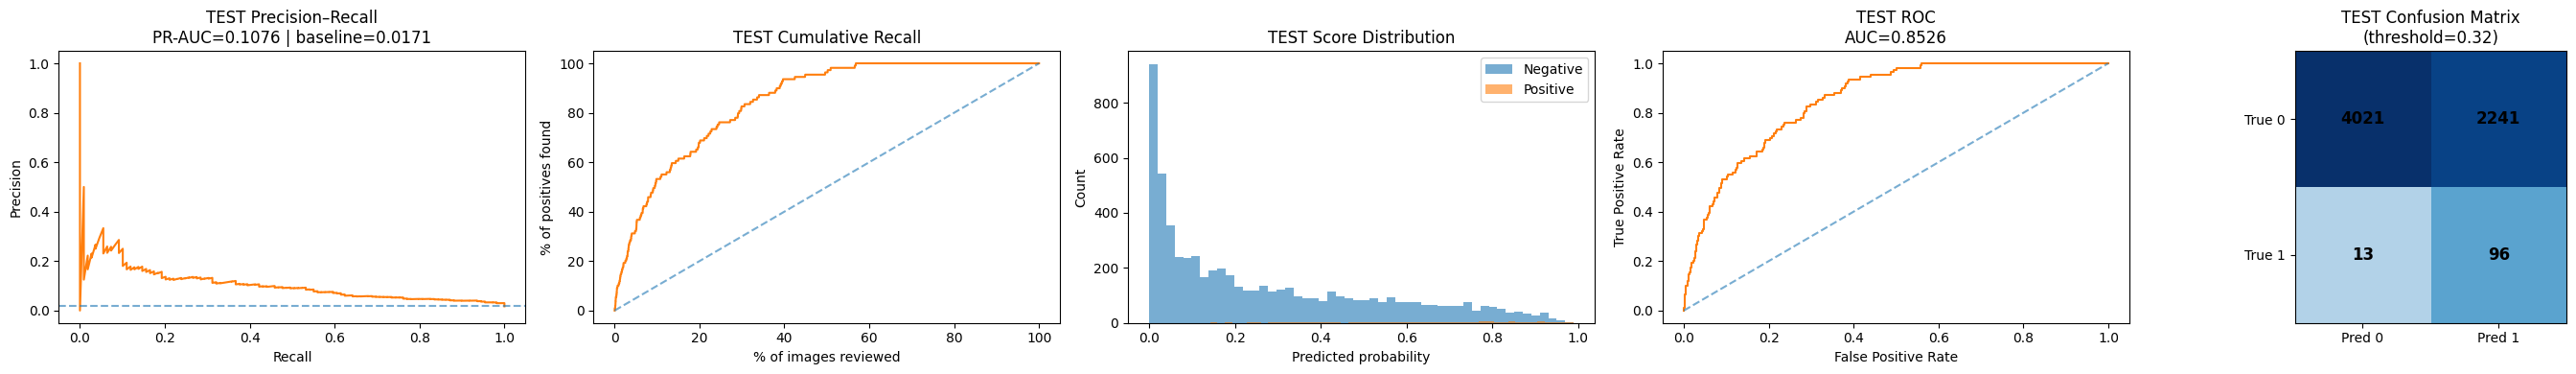

INFO: Final (Stage2 best) test: test_pr=0.10762 | test_roc=0.8526


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

IMG_SIZE = 224
BATCH_SIZE = 32
PATIENCE = 2

EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 5

LR_HEAD_STAGE1 = 1e-3
LR_HEAD_STAGE2 = 1e-3
LR_LASTBLOCK_STAGE2 = 1e-4

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

logger.info("Train prevalence (%%): %.2f", 100 * float(train_df["target"].mean()))

train_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),

        # geometry
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            scale=(0.90, 1.10),
            rotate=(-20, 20),
            p=0.9,
        ),

        # color / lighting
        A.RandomBrightnessContrast(p=0.6),
        A.HueSaturationValue(p=0.4),
        A.RandomGamma(p=0.3),

        # robustness
        A.OneOf(
            [
                A.GaussianBlur(blur_limit=3, p=1.0),
                A.MotionBlur(blur_limit=3, p=1.0),
                A.GaussNoise(std_range=(0.02, 0.08), p=1.0),
            ],
            p=0.3,
        ),

        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

eval_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

class ISICDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        with Image.open(row["filepath"]) as im:
            img = np.array(im.convert("RGB"))
        x = self.tfms(image=img)["image"]
        y = torch.tensor(float(row["target"]), dtype=torch.float32)
        return x, y

train_loader = DataLoader(ISICDataset(train_df, train_tfms), batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=(device.type == "cuda"))
val_loader   = DataLoader(ISICDataset(val_df,   eval_tfms),  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=(device.type == "cuda"))
test_loader  = DataLoader(ISICDataset(test_df,  eval_tfms),  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=(device.type == "cuda"))

# Model
try:
    weights = models.EfficientNet_B0_Weights.DEFAULT
    model = models.efficientnet_b0(weights=weights)
except AttributeError:
    model = models.efficientnet_b0(pretrained=True)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)
model = model.to(device)

# Imbalance handling (pos_weight)
y_train_np = train_df["target"].values.astype(np.float32)
pos = float(y_train_np.sum())
neg = float(len(y_train_np) - pos)
pos_weight = None if pos == 0 else torch.tensor([neg / pos], dtype=torch.float32, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
logger.info("pos_weight: %s", None if pos_weight is None else round(float(pos_weight.item()), 2))

def eval_pr_roc(model, loader):
    model.eval()
    y_list, p_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            probs = torch.sigmoid(model(x).squeeze(1)).cpu().numpy()
            p_list.append(probs)
            y_list.append(y.numpy())
    y_true = np.concatenate(y_list)
    y_prob = np.concatenate(p_list)
    return float(average_precision_score(y_true, y_prob)), float(roc_auc_score(y_true, y_prob))

# Stage 1: Train head-only
for p in model.features.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=LR_HEAD_STAGE1, weight_decay=1e-4)

best_val_pr = -1.0
bad_epochs = 0
ckpt_stage1 = artifact_output_directory / "effb0_stage1_head_only_best.pt"

for epoch in range(1, EPOCHS_STAGE1 + 1):
    model.train()
    losses = []

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        loss = criterion(model(x).squeeze(1), y)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.detach().cpu().item()))

    train_loss = float(np.mean(losses)) if losses else float("nan")
    val_pr, val_roc = eval_pr_roc(model, val_loader)

    logger.info("S1 epoch=%d | loss=%.4f | val_pr=%.5f | val_roc=%.4f", epoch, train_loss, val_pr, val_roc)

    if val_pr > best_val_pr:
        best_val_pr = val_pr
        bad_epochs = 0
        torch.save({"model_state": model.state_dict(), "img_size": IMG_SIZE}, str(ckpt_stage1))
        logger.info("S1 saved best: %s", ckpt_stage1.name)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            logger.info("S1 early stopping (patience=%d)", PATIENCE)
            break

logger.info("Stage 1 best_val_pr=%.5f | ckpt=%s", best_val_pr, ckpt_stage1.name)

# Load best Stage 1 before Stage 2
ckpt = torch.load(str(ckpt_stage1), map_location=device)
model.load_state_dict(ckpt["model_state"])

# Stage 2: Fine-tune last block + head
for p in model.features.parameters():
    p.requires_grad = False
for p in model.features[-1].parameters():
    p.requires_grad = True
for p in model.classifier.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(
    [
        {"params": model.classifier.parameters(), "lr": LR_HEAD_STAGE2},
        {"params": model.features[-1].parameters(), "lr": LR_LASTBLOCK_STAGE2},
    ],
    weight_decay=1e-4,
)

ckpt_stage2 = artifact_output_directory / "effb0_stage2_lastblock_best.pt"
best_val_pr2 = -1.0
bad_epochs = 0

for epoch in range(1, EPOCHS_STAGE2 + 1):
    model.train()
    losses = []

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        loss = criterion(model(x).squeeze(1), y)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.detach().cpu().item()))

    train_loss = float(np.mean(losses)) if losses else float("nan")
    val_pr, val_roc = eval_pr_roc(model, val_loader)

    logger.info("S2 epoch=%d | loss=%.4f | val_pr=%.5f | val_roc=%.4f", epoch, train_loss, val_pr, val_roc)

    if val_pr > best_val_pr2:
        best_val_pr2 = val_pr
        bad_epochs = 0
        torch.save({"model_state": model.state_dict(), "img_size": IMG_SIZE}, str(ckpt_stage2))
        logger.info("S2 saved best: %s", ckpt_stage2.name)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            logger.info("S2 early stopping (patience=%d)", PATIENCE)
            break

logger.info("Stage 2 best_val_pr=%.5f | ckpt=%s", best_val_pr2, ckpt_stage2.name)

# Evaluate best Stage 2 on Test
if not ckpt_stage2.exists():
    raise FileNotFoundError(f"Stage 2 checkpoint not saved: {ckpt_stage2}")

ckpt = torch.load(str(ckpt_stage2), map_location=device)
model.load_state_dict(ckpt["model_state"])

#plot
def collect_probs_from_loader(model, loader):
    model.eval()
    y_list, p_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            p = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
            y_list.append(y.detach().cpu().numpy())
            p_list.append(p)
    y_true = np.concatenate(y_list).astype(int)
    p_prob = np.concatenate(p_list)
    return y_true, p_prob

y_val,  p_val  = collect_probs_from_loader(model, val_loader)
y_test, p_test = collect_probs_from_loader(model, test_loader)

target_recall = 0.85
precision, recall, thresholds = precision_recall_curve(y_val, p_val)

# thresholds aligns with precision[1:], recall[1:]
precision_t = precision[1:]
recall_t = recall[1:]

valid = np.where(recall_t >= target_recall)[0]
if len(valid) == 0:
    chosen_thresh = 0.5
else:
    i = valid[np.argmax(precision_t[valid])]
    chosen_thresh = float(thresholds[i])

print(f"Chosen threshold (VAL, recall≥{target_recall:.2f}): {chosen_thresh:.6f}")

print("Model Diagnostics")
print("Validation")
plot_model_diagnostics(y_val, p_val, name="VALIDATION", color="tab:green", threshold=chosen_thresh)

print("Test")
plot_model_diagnostics(y_test, p_test, name="TEST", color="tab:orange", threshold=chosen_thresh)


test_pr, test_roc = eval_pr_roc(model, test_loader)
logger.info("Final (Stage2 best) test: %s", info_dict({"test_pr": round(test_pr, 5), "test_roc": round(test_roc, 4)}))

gc.collect()
if device.type == "cuda":
    torch.cuda.empty_cache()


##Confusion matrix

Chosen threshold (VAL, recall≥0.95): 0.065699

TEST Confusion Matrix
[[2241 4021]
 [   1  108]]
tn=2241 fp=4021 fn=1 tp=108
TEST recall    : 99.08%
TEST precision : 2.62%
TEST FPR       : 64.21%

TEST Classification Report
              precision    recall  f1-score   support

           0     0.9996    0.3579    0.5270      6262
           1     0.0262    0.9908    0.0510       109

    accuracy                         0.3687      6371
   macro avg     0.5129    0.6743    0.2890      6371
weighted avg     0.9829    0.3687    0.5189      6371



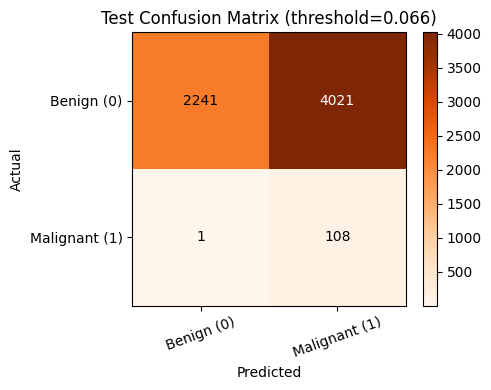

In [24]:
def collect_probs(model, loader):
    model.eval()
    probs_list, y_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            p = torch.sigmoid(model(x).squeeze(1)).cpu().numpy()
            probs_list.append(p)
            y_list.append(y.numpy())
    return np.concatenate(y_list).astype(int), np.concatenate(probs_list)

y_val, p_val = collect_probs(model, val_loader)
y_test, p_test = collect_probs(model, test_loader)

# Picked traget recall to be >= 0.95
target_recall = 0.95
precision, recall, thresholds = precision_recall_curve(y_val, p_val)

valid_idx = np.where(recall >= target_recall)[0]

if len(valid_idx) == 0:
    chosen_thresh = 0.5
else:
    best_i = valid_idx[np.argmax(precision[valid_idx])]
    thresh_i = max(best_i - 1, 0)
    chosen_thresh = float(thresholds[thresh_i])

print(f"Chosen threshold (VAL, recall≥{target_recall:.2f}): {chosen_thresh:.6f}")


#Confusion matrix on Test
test_pred = (p_test >= chosen_thresh).astype(int)
cm = confusion_matrix(y_test, test_pred)
tn, fp, fn, tp = cm.ravel()

test_recall = tp / (tp + fn) if (tp + fn) else 0.0
test_precision = tp / (tp + fp) if (tp + fp) else 0.0
test_fpr = fp / (fp + tn) if (fp + tn) else 0.0

print("\nTEST Confusion Matrix")
print(cm)
print(f"tn={tn} fp={fp} fn={fn} tp={tp}")
print(f"TEST recall    : {100*test_recall:.2f}%")
print(f"TEST precision : {100*test_precision:.2f}%")
print(f"TEST FPR       : {100*test_fpr:.2f}%")

print("\nTEST Classification Report")
print(classification_report(y_test, test_pred, digits=4))

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest", cmap="Oranges")
plt.title(f"Test Confusion Matrix (threshold={chosen_thresh:.3f})")
plt.colorbar()

tick_labels = ["Benign (0)", "Malignant (1)"]
plt.xticks([0, 1], tick_labels, rotation=20)
plt.yticks([0, 1], tick_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Annotate counts (auto-switch text color for readability)
max_val = cm.max() if cm.size else 0
for i in range(2):
    for j in range(2):
        val = cm[i, j]
        text_color = "white" if val > 0.6 * max_val else "black"
        plt.text(j, i, str(val), ha="center", va="center", color=text_color)

plt.tight_layout()
plt.show()


In [25]:
targets = [0.80, 0.85, 0.90, 0.95]
precision, recall, thresholds = precision_recall_curve(y_val, p_val)
precision_t, recall_t = precision[1:], recall[1:]

def pick_thresh(target_recall):
    valid = np.where(recall_t >= target_recall)[0]
    if len(valid) == 0:
        return 0.5
    i = valid[np.argmax(precision_t[valid])]
    return float(thresholds[i])

for R in targets:
    thr = pick_thresh(R)
    pred = (p_test >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    rec = tp / (tp + fn)
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    fpr = fp / (fp + tn)
    print(f"R={R:.2f} thr={thr:.4f} | test_recall={rec:.3f} test_prec={prec:.3f} test_fpr={fpr:.3f}")


R=0.80 thr=0.2858 | test_recall=0.826 test_prec=0.042 test_fpr=0.330
R=0.85 thr=0.2095 | test_recall=0.908 test_prec=0.037 test_fpr=0.407
R=0.90 thr=0.1144 | test_recall=0.963 test_prec=0.030 test_fpr=0.537
R=0.95 thr=0.0657 | test_recall=0.991 test_prec=0.026 test_fpr=0.642


##STACKING - Convolutional Neural Network (CNN) Model - EfficientNet-B0 with Metadata Probability

This code first collects probability outputs from the trained CNN on the validation and test sets and aligns them with the true labels.
It then generates prediction probabilities from a metadata-based model using the same feature columns it was trained on.
Both prediction sources are combined into a two-feature input and used to train a logistic-regression stacker on the validation set.
The fitted stacker is applied to the test set to produce final ensemble probabilities and evaluate PR-AUC and ROC-AUC.
Finally, the stacked model’s performance is compared against the standalone CNN and metadata models to quantify the ensemble gain.

META val PR-AUC: 0.01839
CNN  val PR-AUC: 0.10043
STACK chosen threshold (VAL, recall≥0.85): 0.350867
Model Diagnostics (STACK)
Validation


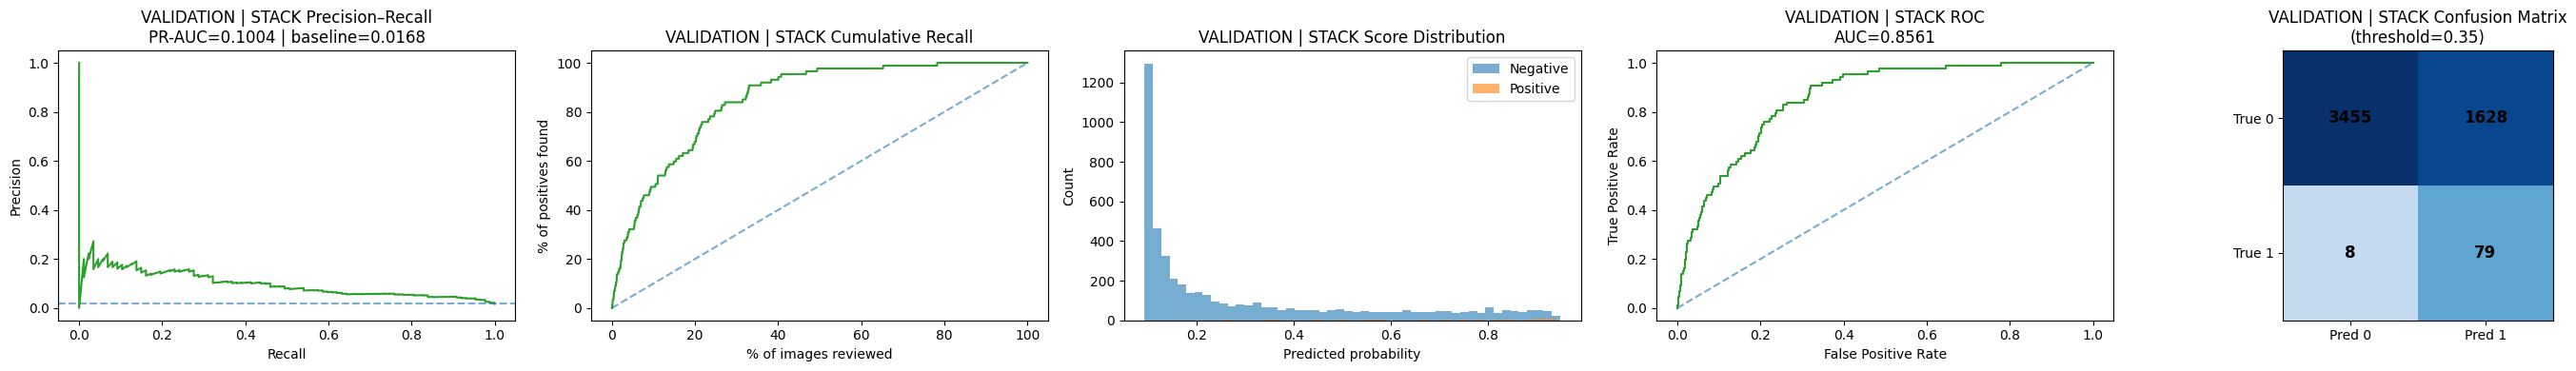

Test


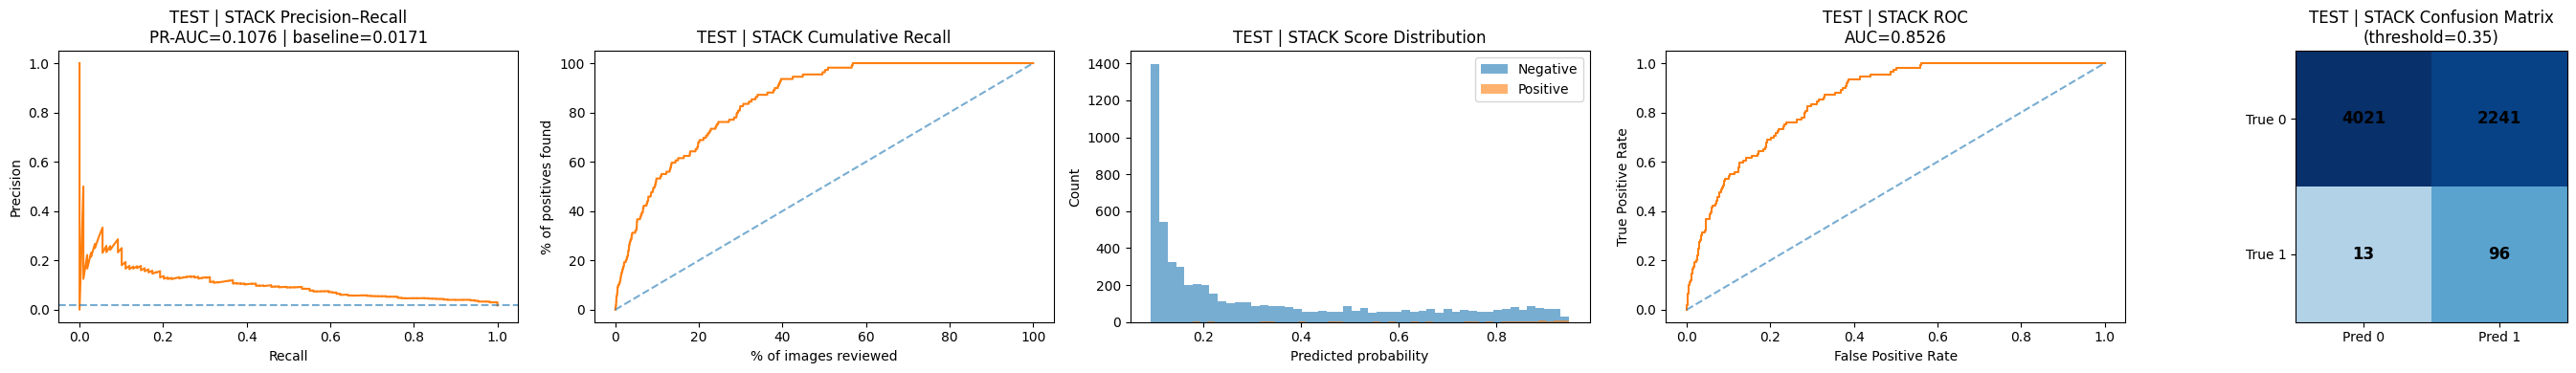

Stacker (CNN + metadata) TEST PR-AUC: 0.10762
Stacker (CNN + metadata) TEST ROC-AUC: 0.8526
Base CNN TEST PR-AUC : 0.10762
Base META TEST PR-AUC: 0.01783


In [35]:
def collect_cnn_probs(model, loader):
    model.eval()
    y_list, p_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            probs = torch.sigmoid(model(x).squeeze(1)).cpu().numpy()
            p_list.append(probs)
            y_list.append(y.numpy())
    return np.concatenate(y_list).astype(int), np.concatenate(p_list)

# CNN probs
y_val_img, p_val_img = collect_cnn_probs(model, val_loader)
y_test_img, p_test_img = collect_cnn_probs(model, test_loader)

assert y_val_img.shape[0] == len(val_df)
assert y_test_img.shape[0] == len(test_df)

# Metadata probs (use SAME feature cols as your metadata model was trained on)
target_col = "target"
categorical_cols = ["sex", "age_bin", "site_grp", "sex_x_site", "agebin_x_site"]
numeric_cols = ["age", "patient_img_count", "patient_any_pos", "patient_pos_rate",
                "age_missing", "sex_missing", "site_missing"]
feature_cols = categorical_cols + numeric_cols

X_val_meta = val_df[feature_cols].copy()
y_val_meta = val_df[target_col].astype(int).values

X_test_meta = test_df[feature_cols].copy()
y_test_meta = test_df[target_col].astype(int).values

# IMPORTANT: use tree_model if that's your metadata baseline
p_val_meta = tree_model.predict_proba(X_val_meta)[:, 1]
p_test_meta = tree_model.predict_proba(X_test_meta)[:, 1]

print("META val PR-AUC:", round(float(average_precision_score(y_val_meta, p_val_meta)), 5))
print("CNN  val PR-AUC:", round(float(average_precision_score(y_val_img, p_val_img)), 5))

assert np.array_equal(y_val_img, y_val_meta)
assert np.array_equal(y_test_img, y_test_meta)

# Stacker (fit on VAL)
X_stack_val = np.column_stack([p_val_img, p_val_meta])
X_stack_test = np.column_stack([p_test_img, p_test_meta])

stacker = LogisticRegression(max_iter=2000, class_weight="balanced")
stacker.fit(X_stack_val, y_val_meta)

p_test_stack = stacker.predict_proba(X_stack_test)[:, 1]
p_val_stack = stacker.predict_proba(X_stack_val)[:, 1]

target_recall = 0.85
precision, recall, thresholds = precision_recall_curve(y_val_meta, p_val_stack)

# thresholds aligns with precision[1:], recall[1:]
precision_t = precision[1:]
recall_t = recall[1:]

valid = np.where(recall_t >= target_recall)[0]
if len(valid) == 0:
    chosen_thresh = 0.5
else:
    i = valid[np.argmax(precision_t[valid])]
    chosen_thresh = float(thresholds[i])

print(f"STACK chosen threshold (VAL, recall≥{target_recall:.2f}): {chosen_thresh:.6f}")

print("Model Diagnostics (STACK)")
print("Validation")
plot_model_diagnostics(y_val_meta, p_val_stack, name="VALIDATION | STACK", color="tab:green", threshold=chosen_thresh)

print("Test")
plot_model_diagnostics(y_test_meta, p_test_stack, name="TEST | STACK", color="tab:orange", threshold=chosen_thresh)

test_pr = float(average_precision_score(y_test_meta, p_test_stack))
test_roc = float(roc_auc_score(y_test_meta, p_test_stack))

print("Stacker (CNN + metadata) TEST PR-AUC:", round(test_pr, 5))
print("Stacker (CNN + metadata) TEST ROC-AUC:", round(test_roc, 4))

base_img_pr = float(average_precision_score(y_test_img, p_test_img))
base_meta_pr = float(average_precision_score(y_test_meta, p_test_meta))

print("Base CNN TEST PR-AUC :", round(base_img_pr, 5))
print("Base META TEST PR-AUC:", round(base_meta_pr, 5))


## Convolutional Neural Network (CNN) Model - EfficientNet-B0 classifier using a two-stage fine-tuning approach with Albumentations-based image augmentation and imbalance handling with **WeightedRandomSampler**

 1) Two-stage fine-tune: (S1) head-only, (S2) last block + head (lower LR)
 2) Imbalance handling : WeightedRandomSampler
 3) Loss : BCEWithLogitsLoss
 4) Stronger Albumentations aug: Affine + color + blur/noise + coarse dropout


INFO: Train prevalence (%): 1.80
INFO: Imbalance mode: sampler
INFO: Loss: bce


device: cuda


INFO: S1 epoch=1 | loss=0.5471 | val_pr=0.09023 | val_roc=0.8445
INFO: S1 saved best: effb0_albu_s2_stage1_head_best.pt
INFO: S1 epoch=2 | loss=0.5099 | val_pr=0.08902 | val_roc=0.8464
INFO: S1 epoch=3 | loss=0.5144 | val_pr=0.09049 | val_roc=0.8456
INFO: S1 saved best: effb0_albu_s2_stage1_head_best.pt
INFO: S1 epoch=4 | loss=0.5092 | val_pr=0.09450 | val_roc=0.8466
INFO: S1 saved best: effb0_albu_s2_stage1_head_best.pt
INFO: S1 epoch=5 | loss=0.5048 | val_pr=0.09530 | val_roc=0.8521
INFO: S1 saved best: effb0_albu_s2_stage1_head_best.pt
INFO: S1 epoch=6 | loss=0.5067 | val_pr=0.08638 | val_roc=0.8435
INFO: S1 epoch=7 | loss=0.5061 | val_pr=0.09667 | val_roc=0.8428
INFO: S1 saved best: effb0_albu_s2_stage1_head_best.pt
INFO: S1 epoch=8 | loss=0.5051 | val_pr=0.08606 | val_roc=0.8442
INFO: S1 epoch=9 | loss=0.5020 | val_pr=0.08791 | val_roc=0.8430
INFO: S1 early stopping (patience=2)
INFO: Stage 1 best_val_pr=0.09667 | ckpt=effb0_albu_s2_stage1_head_best.pt
INFO: S2 epoch=1 | loss=0.48

Chosen threshold (VAL, recall≥0.85): 0.441482
Model Diagnostics
Validation


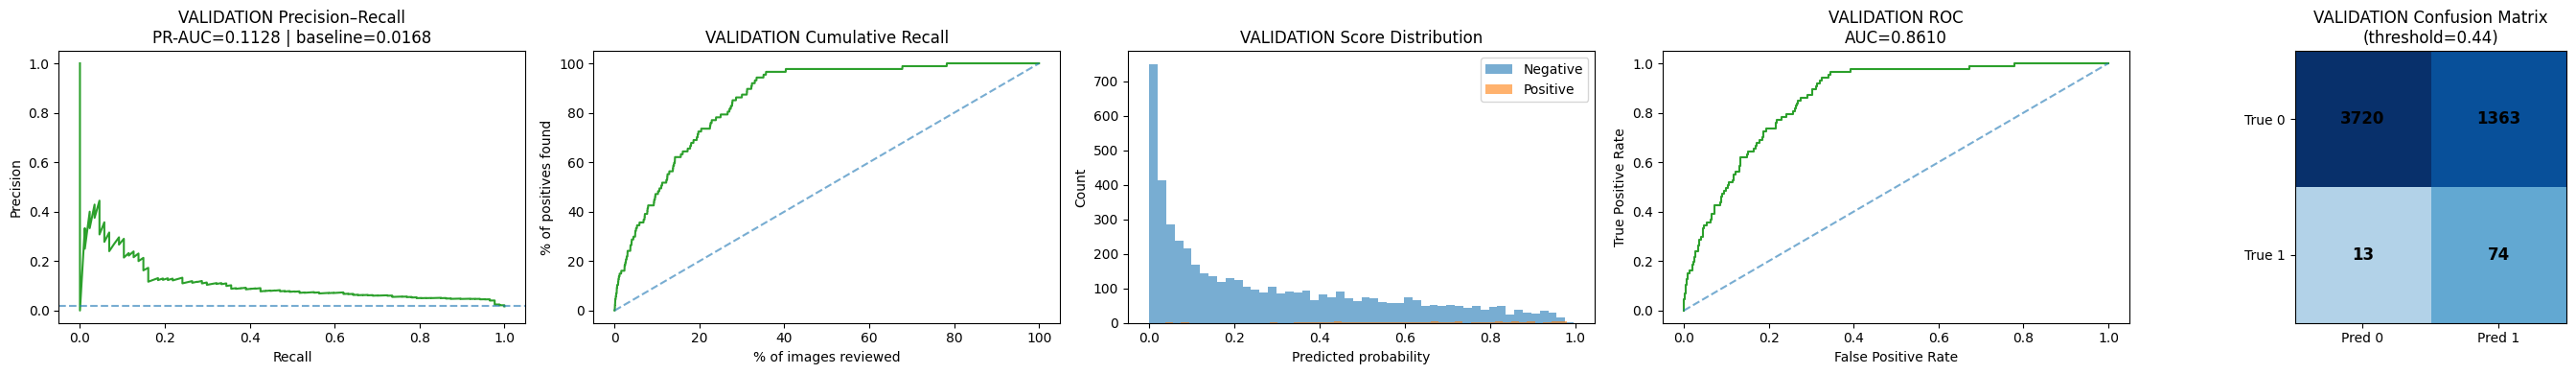

Test


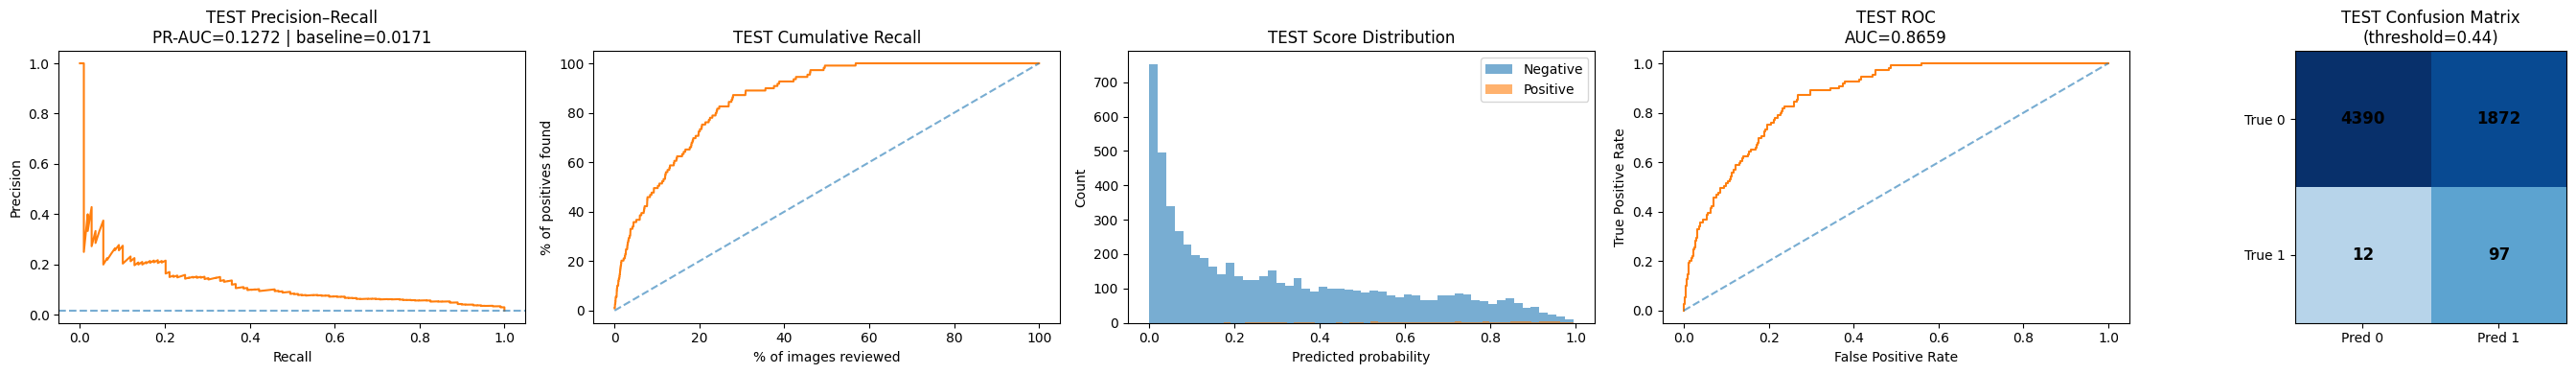

INFO: Final (Stage2 best) test: test_pr=0.12724 | test_roc=0.8659


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

IMG_SIZE = 224
BATCH_SIZE = 32
PATIENCE = 2

EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 5

LR_HEAD_STAGE1 = 1e-3
LR_HEAD_STAGE2 = 5e-4        # slightly lower than stage1
LR_LASTBLOCK_STAGE2 = 1e-4   # fine-tune backbone gently

# Pick ONE imbalance strategy:
USE_SAMPLER = True
USE_POS_WEIGHT = False
# (don’t use both)
assert not (USE_SAMPLER and USE_POS_WEIGHT)

# Loss option:
USE_FOCAL = False            # True = focal loss; False = BCEWithLogitsLoss
FOCAL_GAMMA = 2.0            # typical 1.5–2.5

run_tag = "effb0_albu_s2"    # change per experiment to keep ckpts unique

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

logger.info("Train prevalence (%%): %.2f", 100 * float(train_df["target"].mean()))
logger.info("Imbalance mode: %s", "sampler" if USE_SAMPLER else ("pos_weight" if USE_POS_WEIGHT else "none"))
logger.info("Loss: %s", "focal" if USE_FOCAL else "bce")

train_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),

        # geometry
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.Affine(
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            scale=(0.90, 1.10),
            rotate=(-20, 20),
            shear=(-8, 8),
            p=0.9,
        ),

        # color / lighting
        A.RandomBrightnessContrast(p=0.6),
        A.HueSaturationValue(p=0.4),
        A.RandomGamma(p=0.3),

        # mild blur/noise
        A.OneOf(
            [
                A.GaussianBlur(blur_limit=3, p=1.0),
                A.MotionBlur(blur_limit=3, p=1.0),
                A.GaussNoise(std_range=(0.02, 0.08), p=1.0),
            ],
            p=0.3,
        ),

        # robustness to occlusion/artifacts
        A.CoarseDropout(
            num_holes_range=(1, 4),
            hole_height_range=(0.05, 0.15),
            hole_width_range=(0.05, 0.15),
            p=0.2,
        ),

        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

eval_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

class ISICDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        with Image.open(row["filepath"]) as im:
            img = np.array(im.convert("RGB"))
        x = self.tfms(image=img)["image"]
        y = torch.tensor(float(row["target"]), dtype=torch.float32)
        return x, y


train_dataset = ISICDataset(train_df, train_tfms)
val_dataset   = ISICDataset(val_df, eval_tfms)
test_dataset  = ISICDataset(test_df, eval_tfms)

train_sampler = None
if USE_SAMPLER:
    y_train = train_df["target"].values.astype(int)
    class_counts = np.bincount(y_train, minlength=2).astype(float)  # [neg, pos]
    class_weights = 1.0 / np.maximum(class_counts, 1.0)
    sample_weights = class_weights[y_train]
    train_sampler = WeightedRandomSampler(
        weights=torch.tensor(sample_weights, dtype=torch.double),
        num_samples=len(sample_weights),
        replacement=True,
    )

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=(train_sampler is None),
    sampler=train_sampler,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

# Model
try:
    weights = models.EfficientNet_B0_Weights.DEFAULT
    model = models.efficientnet_b0(weights=weights)
except AttributeError:
    model = models.efficientnet_b0(pretrained=True)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)
model = model.to(device)

pos_weight = None
if USE_POS_WEIGHT:
    y_train_np = train_df["target"].values.astype(np.float32)
    pos = float(y_train_np.sum())
    neg = float(len(y_train_np) - pos)
    pos_weight = None if pos == 0 else torch.tensor([neg / pos], dtype=torch.float32, device=device)
    logger.info("pos_weight: %s", None if pos_weight is None else round(float(pos_weight.item()), 2))

bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()

def focal_loss(logits, targets, gamma=2.0):
    # targets: float {0,1}
    bce_per = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction="none")
    p = torch.sigmoid(logits)
    pt = p * targets + (1 - p) * (1 - targets)
    loss = bce_per * ((1 - pt) ** gamma)
    return loss.mean()

def eval_pr_roc(model, loader):
    model.eval()
    y_list, p_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            probs = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
            p_list.append(probs)
            y_list.append(y.numpy())
    y_true = np.concatenate(y_list)
    y_prob = np.concatenate(p_list)
    return float(average_precision_score(y_true, y_prob)), float(roc_auc_score(y_true, y_prob))

# Stage 1: Head-only
for p in model.features.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=LR_HEAD_STAGE1, weight_decay=1e-4)

best_val_pr_s1 = -1.0
bad_epochs = 0
ckpt_s1 = artifact_output_directory / f"{run_tag}_stage1_head_best.pt"

for epoch in range(1, EPOCHS_STAGE1 + 1):
    model.train()
    losses = []

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(x).squeeze(1)

        if USE_FOCAL:
            loss = focal_loss(logits, y, gamma=FOCAL_GAMMA)
        else:
            loss = bce(logits, y)

        loss.backward()
        optimizer.step()
        losses.append(float(loss.detach().cpu().item()))

    train_loss = float(np.mean(losses)) if losses else float("nan")
    val_pr, val_roc = eval_pr_roc(model, val_loader)

    logger.info("S1 epoch=%d | loss=%.4f | val_pr=%.5f | val_roc=%.4f", epoch, train_loss, val_pr, val_roc)

    if val_pr > best_val_pr_s1:
        best_val_pr_s1 = val_pr
        bad_epochs = 0
        torch.save({"model_state": model.state_dict(), "img_size": IMG_SIZE}, str(ckpt_s1))
        logger.info("S1 saved best: %s", ckpt_s1.name)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            logger.info("S1 early stopping (patience=%d)", PATIENCE)
            break

# Load best S1
ckpt = torch.load(str(ckpt_s1), map_location=device)
model.load_state_dict(ckpt["model_state"])
logger.info("Stage 1 best_val_pr=%.5f | ckpt=%s", best_val_pr_s1, ckpt_s1.name)

# Stage 2: Fine-tune last block + head
for p in model.features.parameters():
    p.requires_grad = False
for p in model.features[-1].parameters():
    p.requires_grad = True
for p in model.classifier.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(
    [
        {"params": model.classifier.parameters(), "lr": LR_HEAD_STAGE2},
        {"params": model.features[-1].parameters(), "lr": LR_LASTBLOCK_STAGE2},
    ],
    weight_decay=1e-4,
)

best_val_pr_s2 = best_val_pr_s1
bad_epochs = 0
ckpt_s2 = artifact_output_directory / f"{run_tag}_stage2_lastblock_best.pt"

for epoch in range(1, EPOCHS_STAGE2 + 1):
    model.train()
    losses = []

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(x).squeeze(1)

        if USE_FOCAL:
            loss = focal_loss(logits, y, gamma=FOCAL_GAMMA)
        else:
            loss = bce(logits, y)

        loss.backward()
        optimizer.step()
        losses.append(float(loss.detach().cpu().item()))

    train_loss = float(np.mean(losses)) if losses else float("nan")
    val_pr, val_roc = eval_pr_roc(model, val_loader)

    logger.info("S2 epoch=%d | loss=%.4f | val_pr=%.5f | val_roc=%.4f", epoch, train_loss, val_pr, val_roc)

    if val_pr > best_val_pr_s2:
        best_val_pr_s2 = val_pr
        bad_epochs = 0
        torch.save({"model_state": model.state_dict(), "img_size": IMG_SIZE}, str(ckpt_s2))
        logger.info("S2 saved best: %s", ckpt_s2.name)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            logger.info("S2 early stopping (patience=%d)", PATIENCE)
            break

logger.info("Stage 2 best_val_pr=%.5f | ckpt=%s", best_val_pr_s2, ckpt_s2.name)


# Evaluate best Stage 2 on TEST
if not ckpt_s2.exists():
    raise FileNotFoundError(f"Stage 2 checkpoint not saved: {ckpt_s2}")

ckpt = torch.load(str(ckpt_s2), map_location=device)
model.load_state_dict(ckpt["model_state"])

#plot
def collect_probs_from_loader(model, loader):
    model.eval()
    y_list, p_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            p = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
            y_list.append(y.detach().cpu().numpy())
            p_list.append(p)
    y_true = np.concatenate(y_list).astype(int)
    p_prob = np.concatenate(p_list)
    return y_true, p_prob

y_val,  p_val  = collect_probs_from_loader(model, val_loader)
y_test, p_test = collect_probs_from_loader(model, test_loader)

target_recall = 0.85
precision, recall, thresholds = precision_recall_curve(y_val, p_val)

# thresholds aligns with precision[1:], recall[1:]
precision_t = precision[1:]
recall_t = recall[1:]

valid = np.where(recall_t >= target_recall)[0]
if len(valid) == 0:
    chosen_thresh = 0.5
else:
    i = valid[np.argmax(precision_t[valid])]
    chosen_thresh = float(thresholds[i])

print(f"Chosen threshold (VAL, recall≥{target_recall:.2f}): {chosen_thresh:.6f}")

print("Model Diagnostics")
print("Validation")
plot_model_diagnostics(y_val, p_val, name="VALIDATION", color="tab:green", threshold=chosen_thresh)

print("Test")
plot_model_diagnostics(y_test, p_test, name="TEST", color="tab:orange", threshold=chosen_thresh)

test_pr, test_roc = eval_pr_roc(model, test_loader)
logger.info(
    "Final (Stage2 best) test: %s",
    info_dict({"test_pr": round(test_pr, 5), "test_roc": round(test_roc, 4)}),
)

gc.collect()
if device.type == "cuda":
    torch.cuda.empty_cache()


##Best F1 score

##Confusion matrix


Best-F1 threshold (VAL): 0.937587
VAL best F1=0.1757 | precision=0.2131 | recall=0.1494

TEST @ Best-F1 threshold
{'thr': 0.9375869035720825, 'tn': np.int64(6213), 'fp': np.int64(49), 'fn': np.int64(95), 'tp': np.int64(14), 'precision': np.float64(0.2222222222222222), 'recall': np.float64(0.12844036697247707), 'f1': np.float64(0.16279069767441862), 'fpr': np.float64(0.007824976045991696), 'pred_pos': 63}
              precision    recall  f1-score   support

           0     0.9849    0.9922    0.9885      6262
           1     0.2222    0.1284    0.1628       109

    accuracy                         0.9774      6371
   macro avg     0.6036    0.5603    0.5757      6371
weighted avg     0.9719    0.9774    0.9744      6371


Fewer-FP threshold (VAL) with recall>=0.95: 0.352311

TEST @ Fewer-FP threshold
{'thr': 0.3523111045360565, 'tn': np.int64(3938), 'fp': np.int64(2324), 'fn': np.int64(10), 'tp': np.int64(99), 'precision': np.float64(0.04085843995047462), 'recall': np.float64(0.908

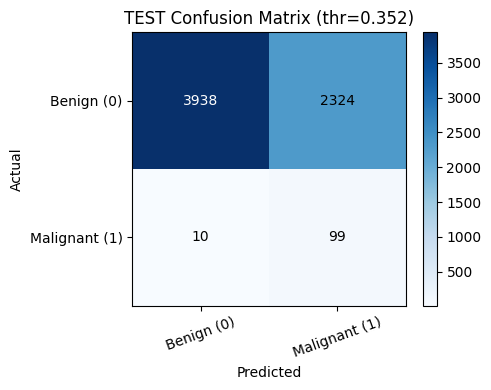

In [39]:

y_val, p_val   = collect_probs(model, val_loader)
y_test, p_test = collect_probs(model, test_loader)


def eval_threshold(y_true, p_prob, thr):
    pred = (p_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0
    fpr       = fp / (fp + tn) if (fp + tn) else 0.0
    return {"thr": float(thr), "tn": tn, "fp": fp, "fn": fn, "tp": tp,
            "precision": precision, "recall": recall, "f1": f1, "fpr": fpr, "pred_pos": int(tp + fp)}

#Best F1 threshold on VAL
prec, rec, thr = precision_recall_curve(y_val, p_val)

# Align to thresholds: use prec[1:], rec[1:] (they correspond to thr)
prec_t = prec[1:]
rec_t  = rec[1:]
f1_t   = 2 * prec_t * rec_t / np.clip(prec_t + rec_t, 1e-12, None)

best_f1_idx = int(np.argmax(f1_t))
best_f1_thr = float(thr[best_f1_idx])

print(f"Best-F1 threshold (VAL): {best_f1_thr:.6f}")
print(f"VAL best F1={f1_t[best_f1_idx]:.4f} | precision={prec_t[best_f1_idx]:.4f} | recall={rec_t[best_f1_idx]:.4f}")

# Evaluate that threshold on TEST
best_f1_test = eval_threshold(y_test, p_test, best_f1_thr)
print("\nTEST @ Best-F1 threshold")
print(best_f1_test)
print(classification_report(y_test, (p_test >= best_f1_thr).astype(int), digits=4))


# keep recall >= some minimum, and minimize FP
min_recall = 0.95

candidate = []
for i, t in enumerate(thr):
    if rec_t[i] >= min_recall:
        candidate.append((t, prec_t[i], rec_t[i], f1_t[i]))

if not candidate:
    fewer_fp_thr = best_f1_thr
    print(f"\nNo thresholds meet recall >= {min_recall:.2f}. Using best-F1 threshold.")
else:
    # Fewer FP generally means higher precision; pick the highest precision among those meeting recall
    fewer_fp_thr = float(max(candidate, key=lambda x: x[1])[0])

print(f"\nFewer-FP threshold (VAL) with recall>={min_recall:.2f}: {fewer_fp_thr:.6f}")

# Evaluate that threshold on TEST
fewer_fp_test = eval_threshold(y_test, p_test, fewer_fp_thr)
print("\nTEST @ Fewer-FP threshold")
print(fewer_fp_test)
print(classification_report(y_test, (p_test >= fewer_fp_thr).astype(int), digits=4))

# onfusion matrix plot for the fewer-FP threshold
cm = confusion_matrix(y_test, (p_test >= fewer_fp_thr).astype(int))
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title(f"TEST Confusion Matrix (thr={fewer_fp_thr:.3f})")
plt.colorbar()
labels = ["Benign (0)", "Malignant (1)"]
plt.xticks([0,1], labels, rotation=20)
plt.yticks([0,1], labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
mx = cm.max()
for i in range(2):
    for j in range(2):
        v = cm[i, j]
        plt.text(j, i, str(v), ha="center", va="center", color=("white" if v > 0.6*mx else "black"))
plt.tight_layout()
plt.show()
